In [ ]:
import numpy as np
import seaborn as sns
import tensorflow
import keras
import os
import glob
from skimage import io
import skimage
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from sklearn.preprocessing import StandardScaler
from skimage import color
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
img_size = (100, 100)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataaaa.zip to dataaaa.zip


In [ ]:
!unzip dataaaa.zip -d ./dataaaa

Archive:  dataaaa.zip
   creating: ./dataaaa/data/
   creating: ./dataaaa/data/test/
   creating: ./dataaaa/data/test/Apple/
  inflating: ./dataaaa/data/test/Apple/r0_103_100.jpg  
  inflating: ./dataaaa/data/test/Apple/r0_107_100.jpg  
  inflating: ./dataaaa/data/test/Apple/r0_111_100.jpg  
  inflating: ./dataaaa/data/test/Apple/r0_115_100.jpg  
  inflating: ./dataaaa/data/test/Apple/r0_119_100.jpg  
  inflating: ./dataaaa/data/test/Apple/r0_11_100.jpg  
  inflating: ./dataaaa/data/test/Apple/r0_123_100.jpg  
  inflating: ./dataaaa/data/test/Apple/r0_127_100.jpg  
  inflating: ./dataaaa/data/test/Apple/r0_131_100.jpg  
  inflating: ./dataaaa/data/test/Apple/r0_135_100.jpg  
  inflating: ./dataaaa/data/test/Apple/r0_139_100.jpg  
  inflating: ./dataaaa/data/test/Apple/r0_143_100.jpg  
  inflating: ./dataaaa/data/test/Apple/r0_147_100.jpg  
  inflating: ./dataaaa/data/test/Apple/r0_151_100.jpg  
  inflating: ./dataaaa/data/test/Apple/r0_155_100.jpg  
  inflating: ./dataaaa/data/test/App

In [ ]:
data = '/content/dataaaa'

In [ ]:
train_dir = "/content/dataaaa/data/train"
test_dir  = "/content/dataaaa/data/test"

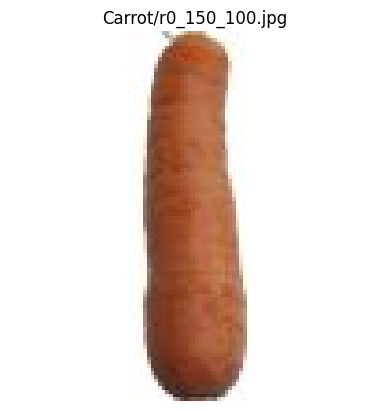

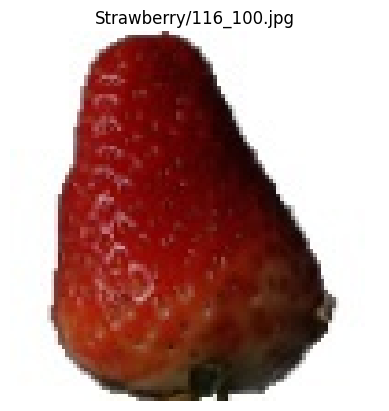

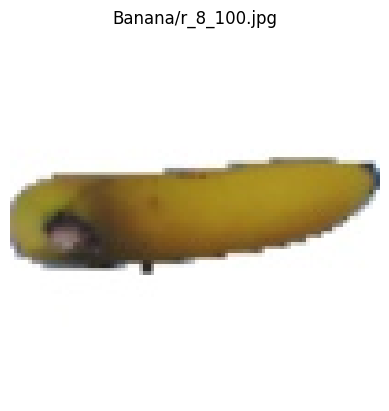

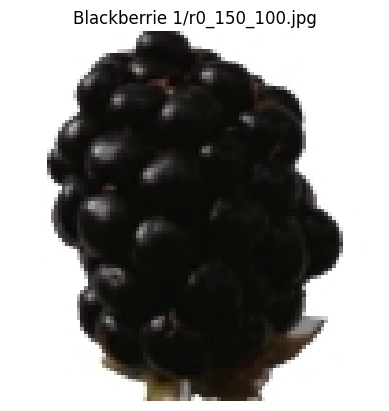

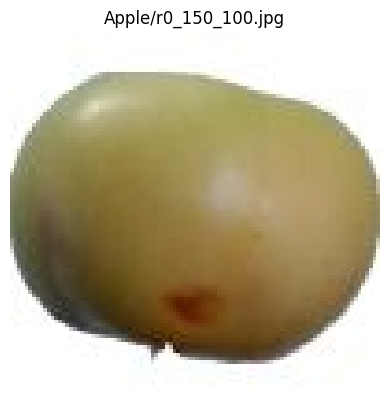

In [ ]:
class_names = os.listdir(train_dir)

# Displaying sample images from each class
for fruit_class in class_names:
    class_path = os.path.join(train_dir, fruit_class)
    if os.path.isdir(class_path):
        sample_images = os.listdir(class_path)
        if sample_images:
            # Take the first image from each class for display
            img_file = sample_images[0]
            img_path = os.path.join(class_path, img_file)
            try:
                img = Image.open(img_path)
                plt.imshow(img)
                plt.title(f"{fruit_class}/{img_file}")
                plt.axis("off")
                plt.show()
            except Exception as e:
                print(f"Could not open image {img_path}: {e}")

In [ ]:
class_names = sorted(os.listdir(train_dir))
class_names

['Apple', 'Banana', 'Blackberrie 1', 'Carrot', 'Strawberry']

##Resizing

In [ ]:
def resize_images(folder_path, img_size=(100, 100)):
    X = []
    y = []

    class_names = sorted(
        d for d in os.listdir(folder_path)
        if os.path.isdir(os.path.join(folder_path, d))
    )

    for label, fruit in enumerate(class_names):
        fruit_folder = os.path.join(folder_path, fruit)

        for filename in os.listdir(fruit_folder):
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            img_path = os.path.join(fruit_folder, filename)

            try:
                img = Image.open(img_path)  # NO RGB conversion
                img = img.resize(img_size, Image.LANCZOS)
                X.append(np.array(img).flatten())
                y.append(label)

            except Exception as e:
                print("Skipped:", img_path, "| Error:", e)

    return np.array(X), np.array(y), class_names

In [ ]:
X_train, y_train, class_names = resize_images(train_dir, img_size)
X_test, y_test, _ = resize_images(test_dir, img_size)

##RGB

In [ ]:
def convert_to_rgb(images_array, img_size):
    rgb_images = []

    for arr in images_array:
        img = Image.fromarray(arr.reshape(img_size[1], img_size[0], -1))
        img = img.convert("RGB")  # convert now
        rgb_images.append(np.array(img).flatten())

    return np.array(rgb_images)


In [ ]:
X_train_rgb = convert_to_rgb(X_train, img_size)
X_test_rgb = convert_to_rgb(X_test, img_size)

In [ ]:
def visualize_rgb(X_rgb, y, folder_path, img_size, samples_per_class=1):
    # Get real class folders
    class_names = sorted(d for d in os.listdir(folder_path)
                         if os.path.isdir(os.path.join(folder_path, d)))

    # Build mapping: label -> folder name
    label_to_class = {i: cls for i, cls in enumerate(class_names)}

    for label in np.unique(y):
        cls_name = label_to_class[label]
        indices = np.where(y == label)[0][:samples_per_class]

        for idx in indices:
            image = X_rgb[idx].reshape(img_size[1], img_size[0], 3)

            fig, axes = plt.subplots(1, 4, figsize=(20, 4))
            titles = ["Original", "Red", "Green", "Blue"]
            images = [image, image[:,:,0], image[:,:,1], image[:,:,2]]
            cmaps = [None, "Reds", "Greens", "Blues"]

            for ax, img, t, cmap in zip(axes, images, titles, cmaps):
                ax.imshow(img, cmap=cmap)
                ax.set_title(t)
                ax.axis("off")

            fig.suptitle(f"Class: {cls_name}", fontsize=16)
            plt.show()



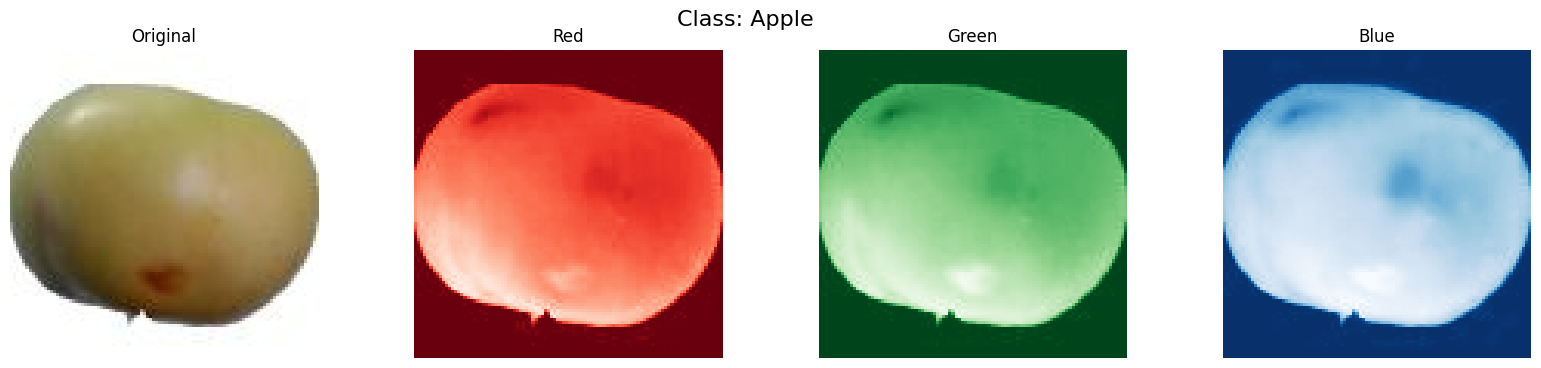

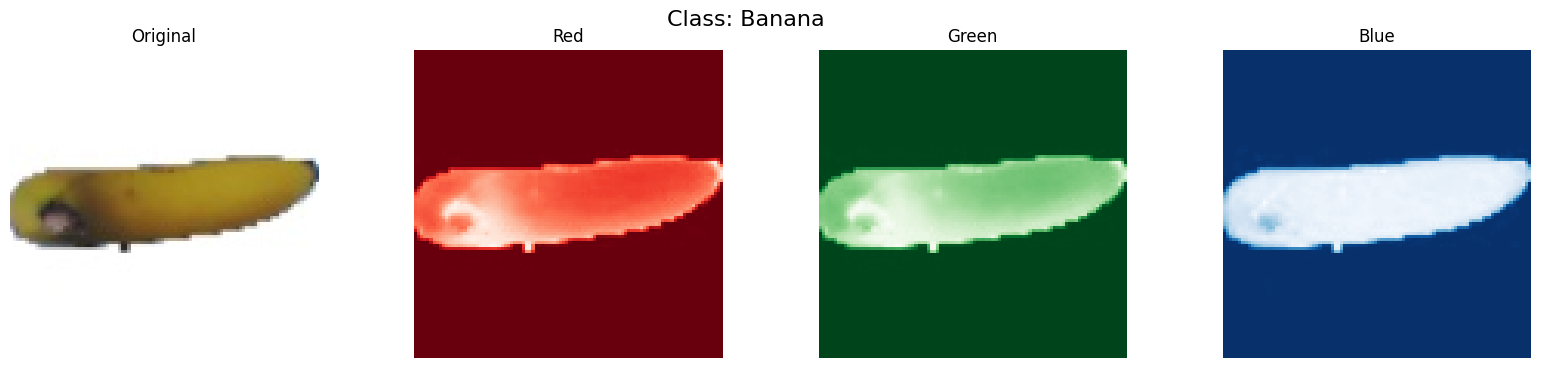

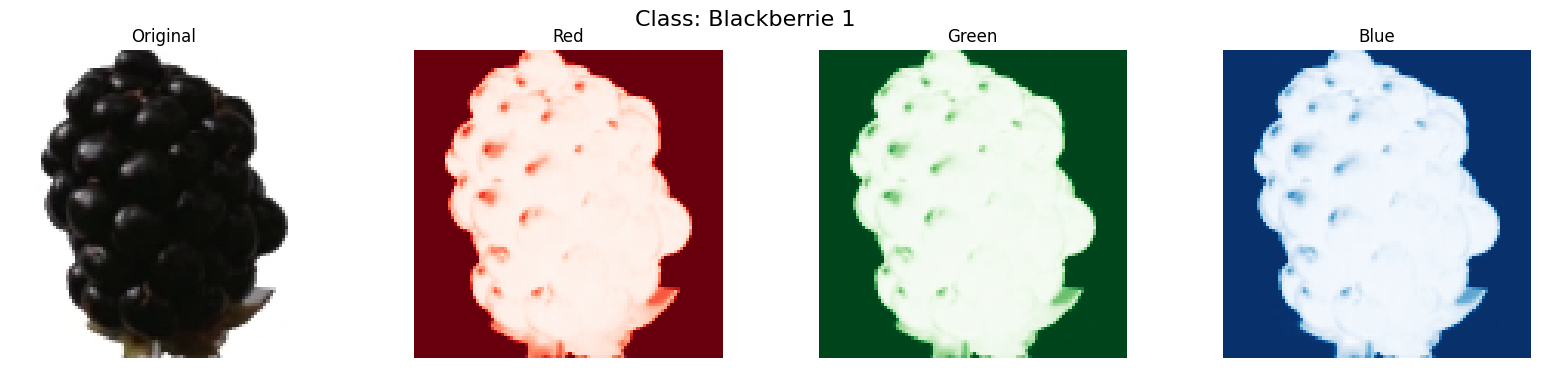

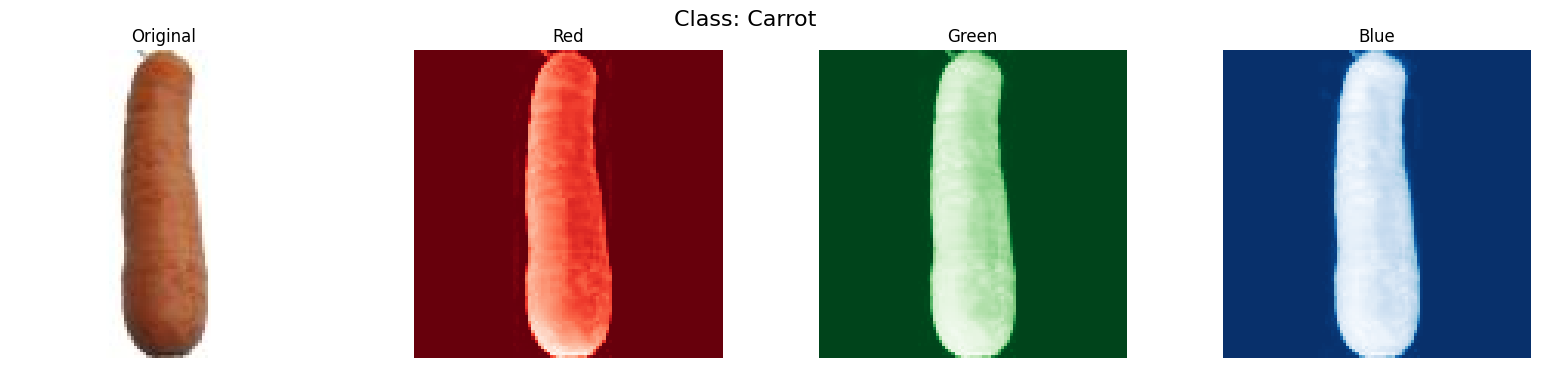

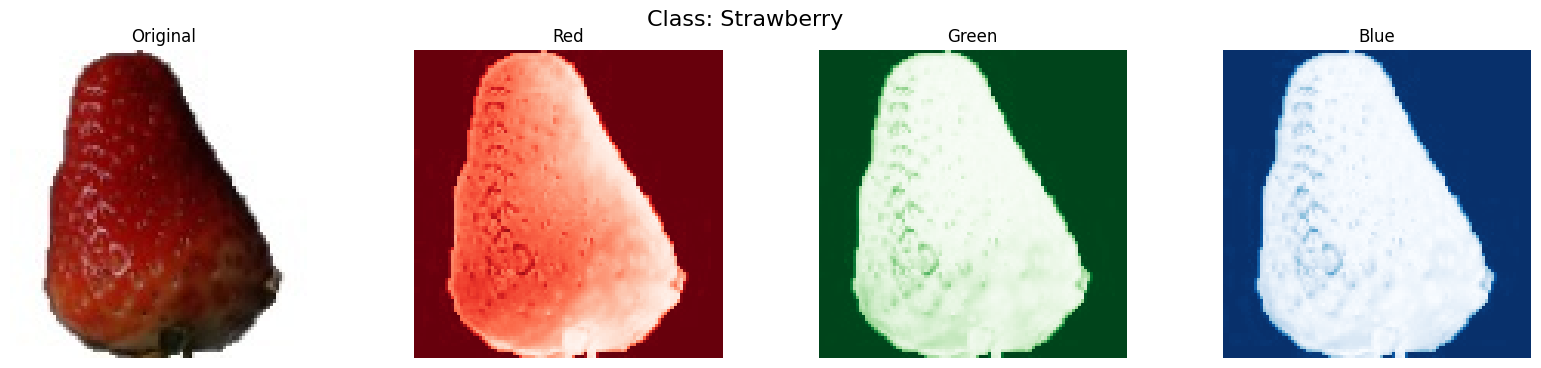

In [ ]:
visualize_rgb(X_train_rgb, y_train, train_dir, img_size=img_size, samples_per_class=1)


In [ ]:
print(X_train_rgb[0].shape)  # Should be width*height*3 if flattened
print(X_train_rgb[0].reshape(img_size[1], img_size[0], 3).shape)  # (H, W, 3)

(30000,)
(100, 100, 3)


In [ ]:
img_array = X_train_rgb[0].reshape(img_size[1], img_size[0], 3)
print(img_array.min(), img_array.max())  # Expect 0–255
print(img_array.dtype)  # Usually uint8


0 255
uint8


In [ ]:
r_channel = img_array[:,:,0]
g_channel = img_array[:,:,1]
b_channel = img_array[:,:,2]

print(r_channel.mean(), g_channel.mean(), b_channel.mean())


181.3361 170.3516 139.5713


##RGB to greyscale

In [ ]:
def rgb_to_grayscale(X_rgb, img_size):

    X_gray = []
    for arr in X_rgb:
        # Reshape to H x W x 3
        img = arr.reshape(img_size[1], img_size[0], 3)
        # Convert to grayscale using skimage
        gray_img = color.rgb2gray(img)  # values in [0,1]
        # Flatten and append
        X_gray.append(gray_img.flatten())

    return np.array(X_gray)

In [ ]:
X_train_gray = rgb_to_grayscale(X_train_rgb, img_size)
X_test_gray = rgb_to_grayscale(X_test_rgb, img_size)

In [ ]:
def visualize_grayscale(X_gray, y, class_names, img_size=(100, 100), samples_per_class=5):

    plt.figure(figsize=(samples_per_class * 2, len(class_names) * 2))

    for label, class_name in enumerate(class_names):

        indices = np.where(y == label)[0][:samples_per_class]

        for i, idx in enumerate(indices):
            img_array = X_gray[idx].reshape(img_size[1], img_size[0])
            plt_idx = label * samples_per_class + i + 1
            plt.subplot(len(class_names), samples_per_class, plt_idx)
            plt.imshow(img_array, cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.ylabel(class_name, rotation=0, labelpad=40, fontsize=12)

    plt.tight_layout()
    plt.show()

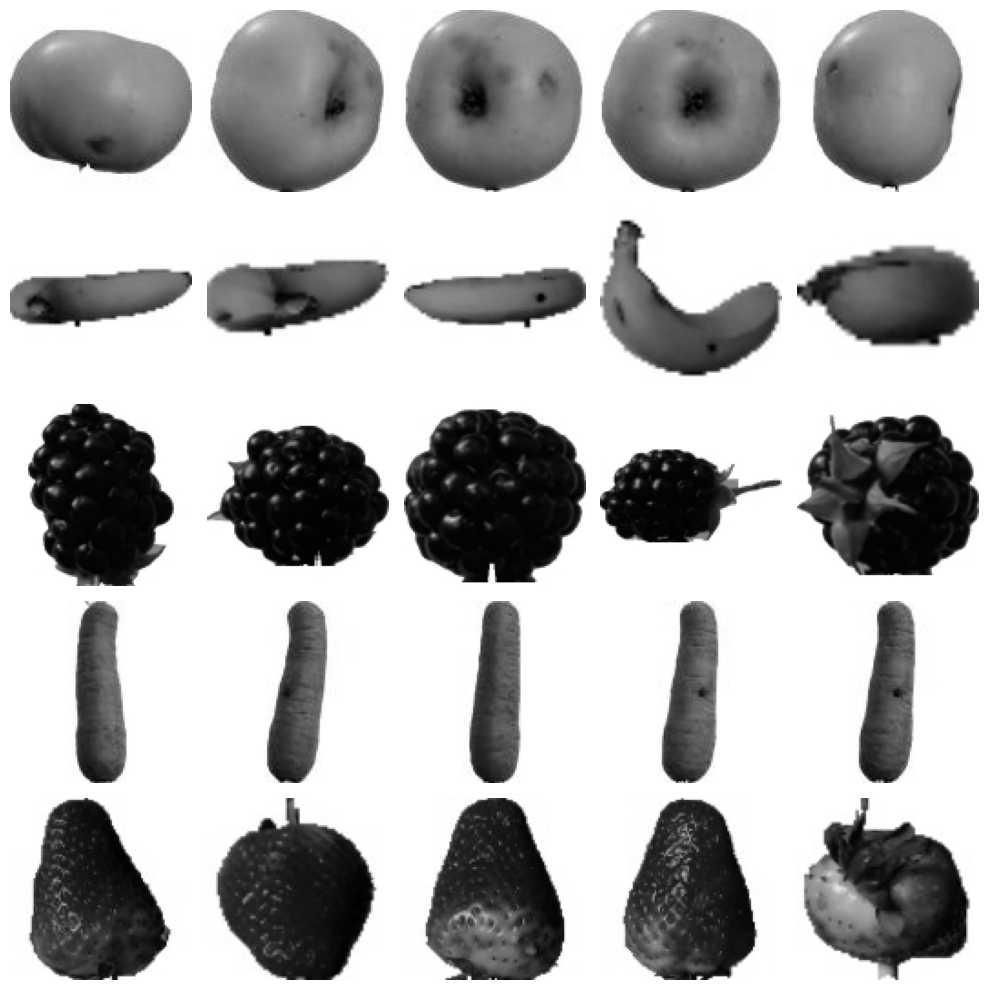

In [ ]:
visualize_grayscale(X_train_gray, y_train, class_names, img_size)


##Normalization

In [ ]:
def normalize_grayscale_dataset(X_gray):
    X_norm = []
    return np.array([(img - img.min()) / (img.max() - img.min()) for img in X_gray])

In [ ]:
X_train_gray_norm = normalize_grayscale_dataset(X_train_gray)
X_test_gray_norm  = normalize_grayscale_dataset(X_test_gray)

In [ ]:
def visualize_normalized_grayscale(X_norm, y, class_names, img_size=(100, 100), samples_per_class=5):
    """
    Visualize normalized grayscale images.

    Parameters:
    X_norm : numpy array
        Flattened normalized grayscale images (values 0-1)
    y : numpy array
        Numeric labels
    class_names : list
        Names of classes
    img_size : tuple
        (width, height)
    samples_per_class : int
        Number of images to display per class
    """
    plt.figure(figsize=(samples_per_class * 2, len(class_names) * 2))

    for label, class_name in enumerate(class_names):
        # Get indices of images in this class
        indices = np.where(y == label)[0][:samples_per_class]

        for i, idx in enumerate(indices):
            img_array = X_norm[idx].reshape(img_size[1], img_size[0])
            plt_idx = label * samples_per_class + i + 1
            plt.subplot(len(class_names), samples_per_class, plt_idx)
            plt.imshow(img_array, cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.ylabel(class_name, rotation=0, labelpad=40, fontsize=12)

    plt.tight_layout()
    plt.show()

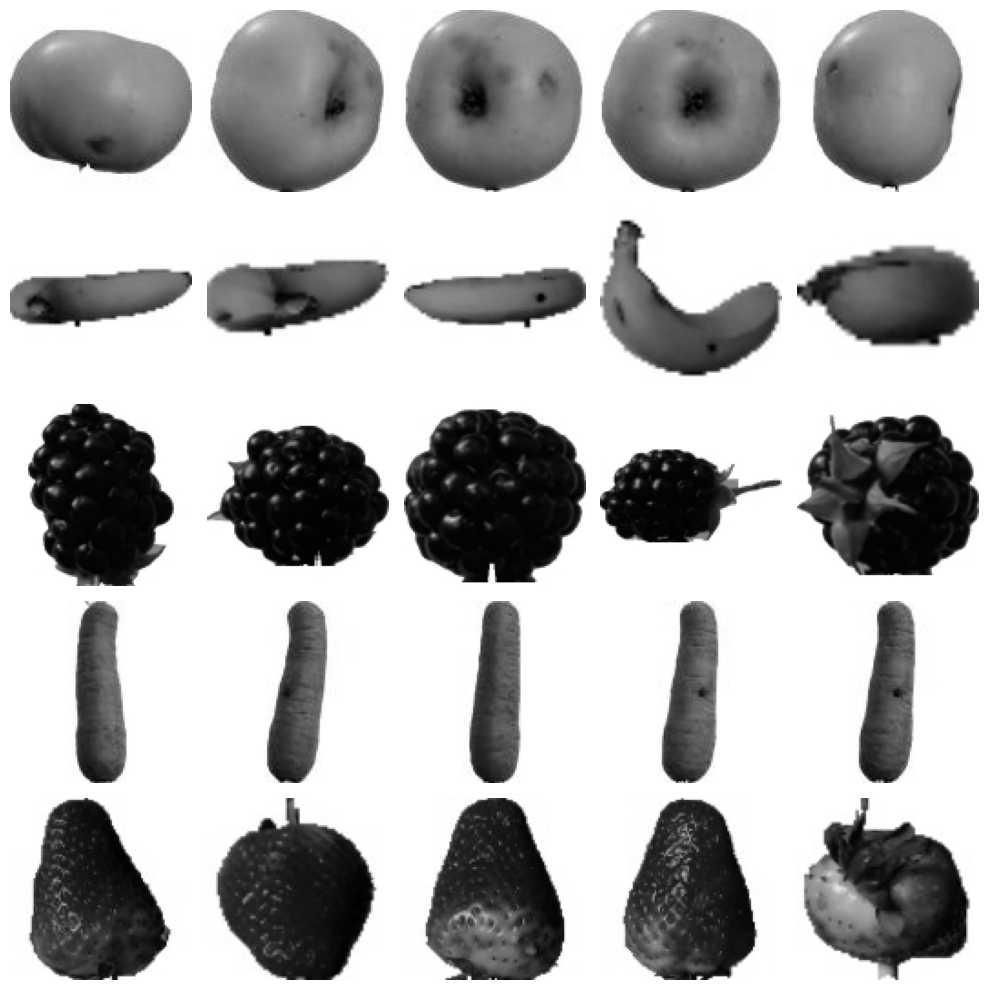

In [ ]:
visualize_normalized_grayscale(X_train_gray_norm, y_train, class_names, img_size=img_size, samples_per_class=5)


In [ ]:
print("Dataset min:", np.min(X_train_gray_norm))
print("Dataset max:", np.max(X_train_gray_norm))

Dataset min: 0.0
Dataset max: 1.0


In [ ]:
for i in range(5):  # check first 5 images
    img = X_train_gray_norm[i]
    print(f"Image {i}: min={np.min(img):.3f}, max={np.max(img):.3f}, mean={np.mean(img):.3f}")


Image 0: min=0.000, max=1.000, mean=0.638
Image 1: min=0.000, max=1.000, mean=0.604
Image 2: min=0.000, max=1.000, mean=0.562
Image 3: min=0.000, max=1.000, mean=0.566
Image 4: min=0.000, max=1.000, mean=0.670


______________________________________________________________________________

##Data augmentation

In [ ]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# 1. Define the augmentation generator for training
train_datagen = ImageDataGenerator(
    rotation_range=40,        # random rotation ±40°
    width_shift_range=0.1,    # horizontal shift
    height_shift_range=0.1,   # vertical shift
    shear_range=0.2,          # shear
    zoom_range=0.2,           # zoom
    horizontal_flip=True,     # horizontal flip
    vertical_flip=True,       # vertical flip
    brightness_range=[0.8,1.2], # brightness adjustment
    fill_mode='nearest'       # fill empty pixels
)

# 2. No augmentation for test/validation
test_datagen = ImageDataGenerator()

# 3. Prepare generators
batch_size = 32

train_generator = train_datagen.flow(
    X_train_rgb.reshape(-1, img_size[0], img_size[1], 3).astype('float32'),
    y_train,
    batch_size=batch_size
)

test_generator = test_datagen.flow(
    X_test_rgb.reshape(-1, img_size[0], img_size[1], 3).astype('float32'),
    y_test,
    batch_size=batch_size
)


In [ ]:
def visualize_augmented_classes(X, y, folder_path, img_size=(100,100), samples_per_class=3):
    """
    Visualize augmented images for each class with correct class names.

    Parameters:
    X : numpy array
        RGB images, shape (num_samples, H*W*3) or (num_samples, H, W, 3)
    y : numpy array
        Numeric labels
    folder_path : str
        Path to the dataset folder to get correct class names
    img_size : tuple
        (width, height)
    samples_per_class : int
        Number of augmented images per class
    """
    # Ensure class names match folder
    class_names = sorted(d for d in os.listdir(folder_path)
                         if os.path.isdir(os.path.join(folder_path, d)))

    # Augmentation generator
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.05,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    for label, class_name in enumerate(class_names):
        # Pick the first image of the class
        idx = np.where(y == label)[0][0]
        img = X[idx].reshape(img_size[1], img_size[0], 3).astype('float32')
        img_batch = np.expand_dims(img, axis=0)

        # Generate augmented images
        aug_iter = datagen.flow(img_batch, batch_size=1)

        plt.figure(figsize=(samples_per_class * 3, 3))
        for i in range(samples_per_class):
            batch = next(aug_iter)
            aug_image = batch[0].astype('uint8')
            plt.subplot(1, samples_per_class, i+1)
            plt.imshow(aug_image)
            plt.axis('off')
            if i == 0:
                plt.title(class_name)


        plt.show()



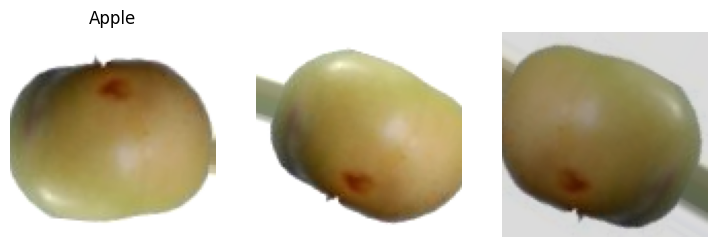

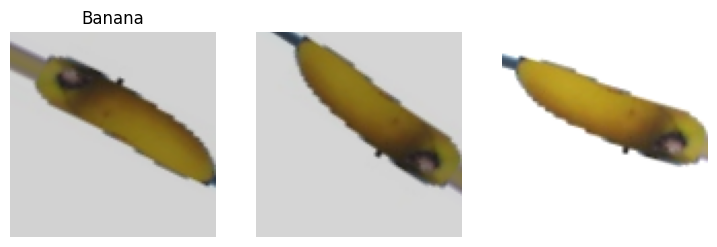

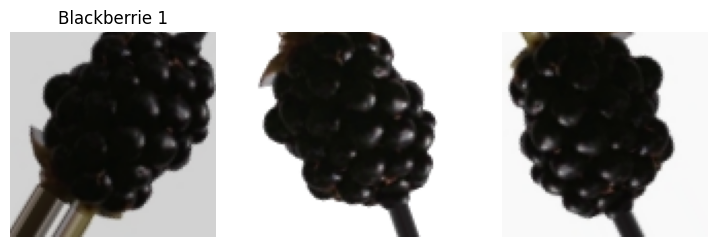

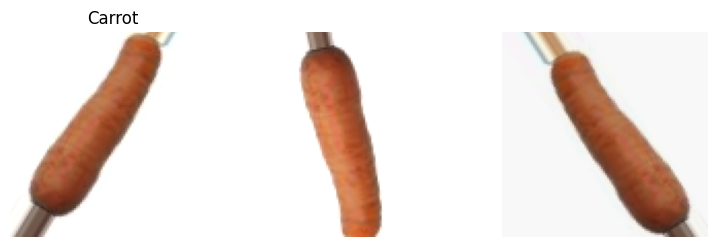

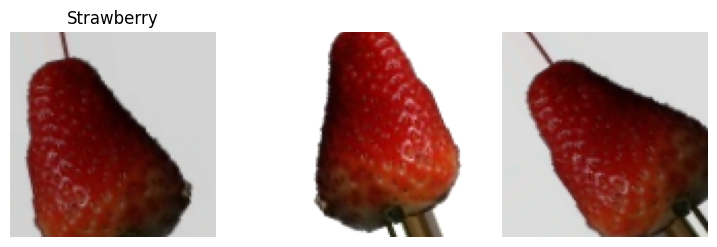

In [ ]:
visualize_augmented_classes(X_train_rgb, y_train, train_dir, img_size=img_size, samples_per_class=3)


##Histogram equalization for contrast enhancements

In [ ]:
import cv2

In [ ]:
def apply_histogram_equalization(X_gray, img_size=(100, 100)):
    """
    Apply histogram equalization to a dataset of grayscale images.

    Parameters:
    X_gray : numpy array
        Grayscale images, shape (num_samples, H*W) or (num_samples, H, W)
    img_size : tuple
        (width, height) of each image

    Returns:
    X_eq : numpy array
        Equalized images, flattened for model input
    """
    X_eq = []
    for img in X_gray:
        # Reshape if flattened
        if img.ndim == 1:
            img_reshaped = img.reshape(img_size[1], img_size[0])
        else:
            img_reshaped = img

        # Ensure uint8 with values 0-255
        img_uint8 = np.clip(img_reshaped * 255, 0, 255).astype('uint8')

        # Apply histogram equalization
        eq_img = cv2.equalizeHist(img_uint8)
        bright_eq_img = cv2.convertScaleAbs(eq_img, alpha=0.5, beta=60)
        # Flatten and scale to 0-1 for model
        X_eq.append(bright_eq_img.flatten() / 255.0)

    return np.array(X_eq)

In [ ]:
# Apply to your training and test data
X_train_eq = apply_histogram_equalization(X_train_gray, img_size=img_size)
X_test_eq  = apply_histogram_equalization(X_test_gray, img_size=img_size)

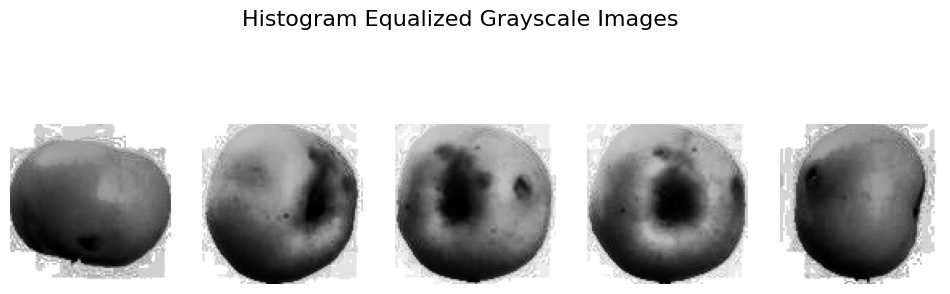

In [ ]:

plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = X_train_eq[i].reshape(img_size[1], img_size[0])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle('Histogram Equalized Grayscale Images', fontsize=16)
plt.show()


In [ ]:
# --- HISTOGRAM VISUALIZATION (Corrected & Clean) ---

import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_histogram_equalization(X_gray, img_size=(100, 100), index=0):
    """
    Visualize original vs equalized image + their histograms.

    Parameters:
    X_gray : array of flattened grayscale images (values 0–1)
    img_size : (W, H)
    index : image index to visualize
    """

    # 1. Get the image and reshape
    img = X_gray[index].reshape(img_size[1], img_size[0])

    # 2. Convert to uint8
    img_uint8 = np.clip(img * 255, 0, 255).astype('uint8')

    # 3. Equalization
    eq_img = cv2.equalizeHist(img_uint8)

    # 4. Optional brightness adjustment
    bright_eq_img = cv2.convertScaleAbs(eq_img, alpha=0.7, beta=40)

    # --- HISTOGRAM COMPARISON ---
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.title("Original Histogram")
    plt.hist(img_uint8.ravel(), bins=256, range=[0,256])

    plt.subplot(1,2,2)
    plt.title("Equalized Histogram")
    plt.hist(bright_eq_img.ravel(), bins=256, range=[0,256])

    plt.show()


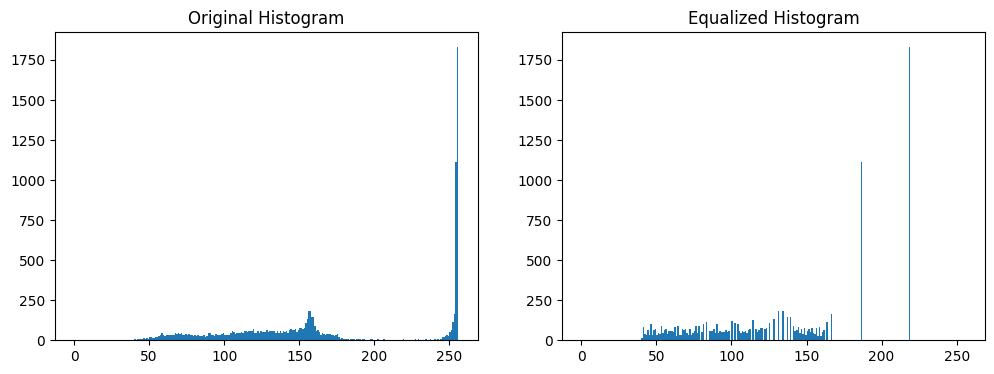

In [ ]:
visualize_histogram_equalization(X_train_gray, img_size=img_size, index=0)


##CLAHE

In [ ]:
def apply_clahe_rgb(images_rgb, img_size=(100, 100), clip_limit=2.0, tile_grid_size=(8, 8)):

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    processed_images = []

    for arr in images_rgb:
        # Reshape to H x W x 3
        img = arr.reshape(img_size[1], img_size[0], 3).astype(np.uint8)

        # Convert RGB to LAB
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE on L channel
        cl = clahe.apply(l)

        # Merge back and convert to RGB
        lab_clahe = cv2.merge((cl, a, b))
        img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

        # Flatten and append
        processed_images.append(img_clahe.flatten())

    return np.array(processed_images)


In [ ]:
X_train_clahe = apply_clahe_rgb(X_train_rgb, img_size)
X_test_clahe  = apply_clahe_rgb(X_test_rgb, img_size)

In [ ]:
def visualize_clahe(X_rgb, y, folder_path, img_size=(100,100), samples_per_class=3,
                            clip_limit=2.0, tile_grid_size=(8,8)):
    """
    Apply CLAHE to all classes and visualize before vs after for multiple samples per class.

    Parameters:
    - X_rgb: np.array of flattened RGB images
    - y: numeric labels
    - folder_path: path to dataset to get class names
    - img_size: (width, height) of images
    - samples_per_class: number of samples to display per class
    - clip_limit: CLAHE clip limit
    - tile_grid_size: CLAHE tile size
    """
    class_names = sorted(d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d)))
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    for label, class_name in enumerate(class_names):
        # Select sample images for this class
        indices = np.where(y == label)[0][:samples_per_class]

        plt.figure(figsize=(samples_per_class * 4, 4))

        for i, idx in enumerate(indices):
            img_flat = X_rgb[idx]
            img = img_flat.reshape(img_size[1], img_size[0], 3).astype(np.uint8)

            # Apply CLAHE
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            cl = clahe.apply(l)
            lab_clahe = cv2.merge((cl, a, b))
            img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

            # Before
            plt.subplot(2, samples_per_class, i + 1)
            plt.imshow(img)
            plt.axis('off')
            if i == 0: plt.title(f'{class_name}\nBefore CLAHE')

            # After
            plt.subplot(2, samples_per_class, i + 1 + samples_per_class)
            plt.imshow(img_clahe)
            plt.axis('off')
            if i == 0: plt.title('After CLAHE')

        plt.tight_layout()
        plt.show()


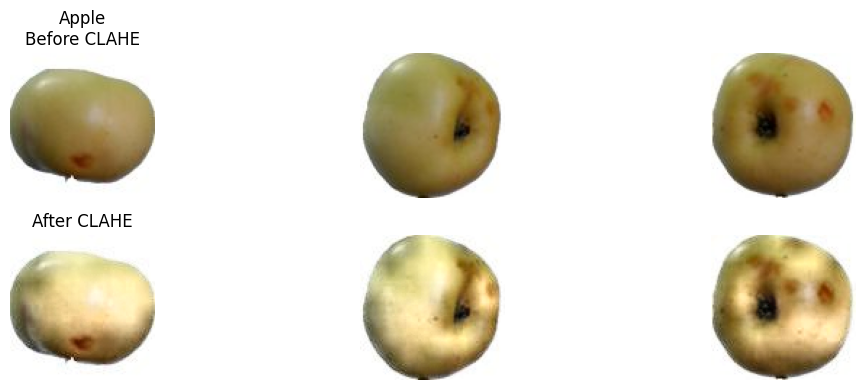

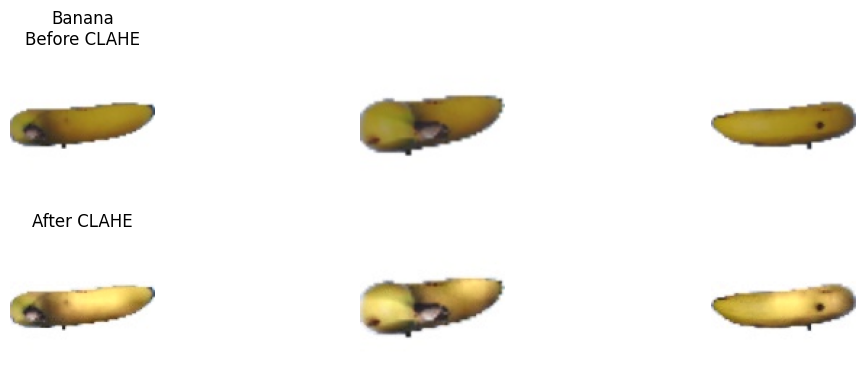

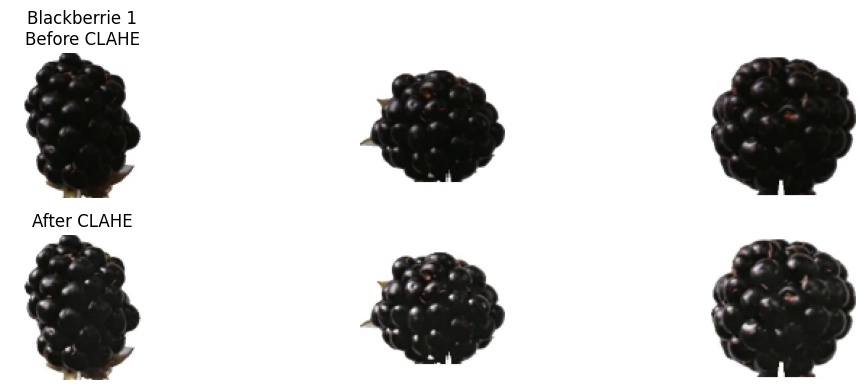

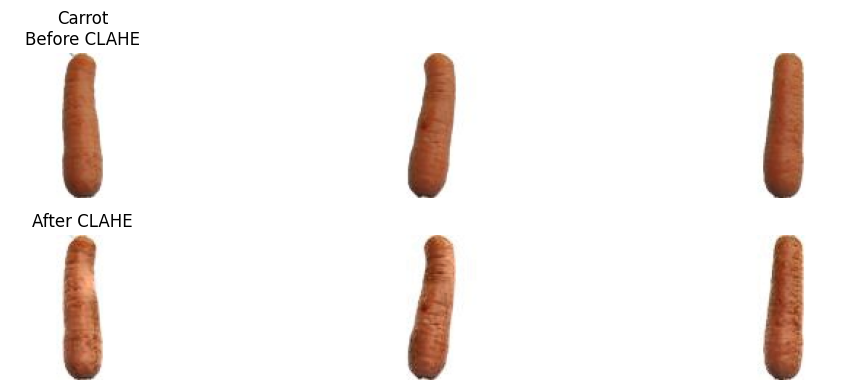

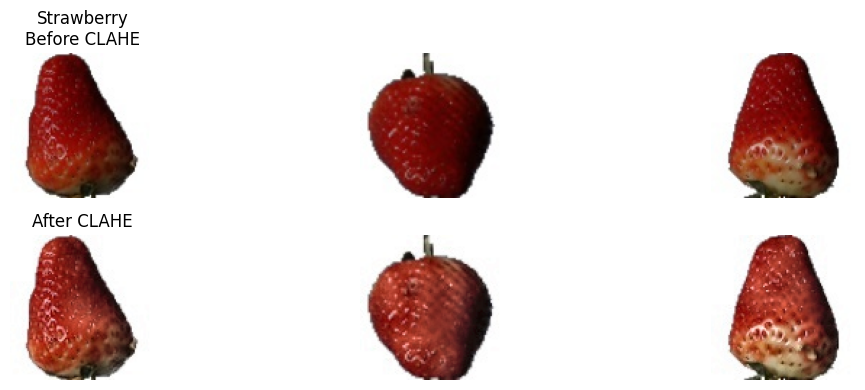

In [ ]:
visualize_clahe(X_train_rgb, y_train, train_dir, img_size=img_size, samples_per_class=3)

##Low pass filters

In [ ]:
def apply_low_pass_filters(X_gray, img_size=(100, 100), kernel_size=3):

    X_mean = []
    X_gaussian = []
    X_median = []

    for img_flat in X_gray:
        img = img_flat.reshape(img_size[1], img_size[0]).astype(np.float32)
        img_uint8 = np.clip(img*255, 0, 255).astype(np.uint8)

        # Mean filter (cv2.blur)
        mean = cv2.blur(img_uint8, (kernel_size, kernel_size))

        # Gaussian Blur (cv2.GaussianBlur)
        gaussian = cv2.GaussianBlur(img_uint8, (kernel_size, kernel_size), 0)

        # Median Filter (cv2.medianBlur)
        median = cv2.medianBlur(img_uint8, kernel_size)

        # Flatten and normalize to 0–1
        X_mean.append(mean.flatten()/255.0)
        X_gaussian.append(gaussian.flatten()/255.0)
        X_median.append(median.flatten()/255.0)

    return np.array(X_mean), np.array(X_gaussian), np.array(X_median)

In [ ]:
X_train_mean, X_train_gaussian, X_train_median = apply_low_pass_filters(X_train_gray_norm, img_size, kernel_size=3)
X_test_mean, X_test_gaussian, X_test_median = apply_low_pass_filters(X_test_gray_norm, img_size, kernel_size=3)


In [ ]:
def visualize_mean_filter(X_mean, y, class_names, img_size=(100,100), samples_per_class=3):
    """
    Visualize Mean-filtered images for all classes.
    """
    for label, class_name in enumerate(class_names):
        indices = np.where(y == label)[0][:samples_per_class]
        plt.figure(figsize=(samples_per_class*3, 3))

        for i, idx in enumerate(indices):
            img_array = X_mean[idx].reshape(img_size[1], img_size[0])
            plt.subplot(1, samples_per_class, i+1)
            plt.imshow(img_array, cmap='gray')
            plt.axis('off')
            if i == 0: plt.title(f"{class_name}\nMean Filter", fontsize=10)

        plt.tight_layout()
        plt.show()



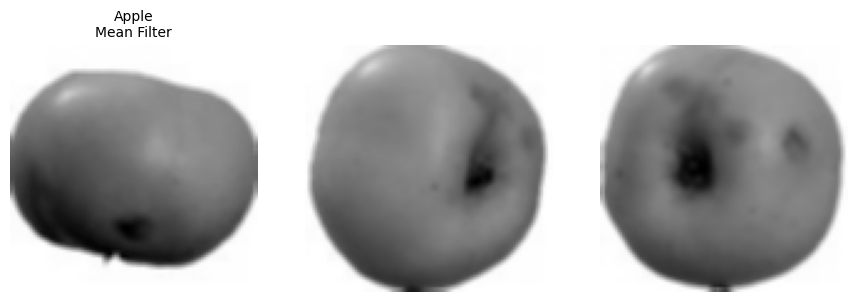

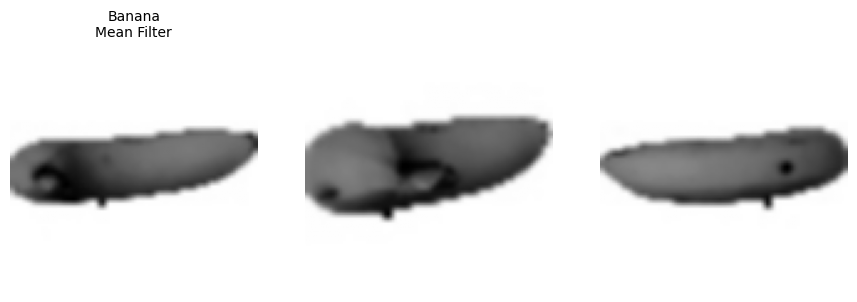

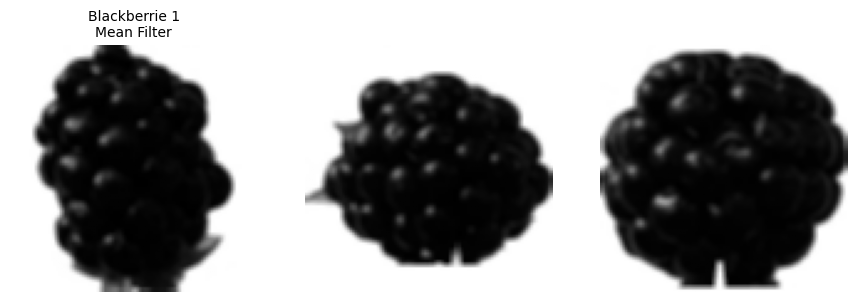

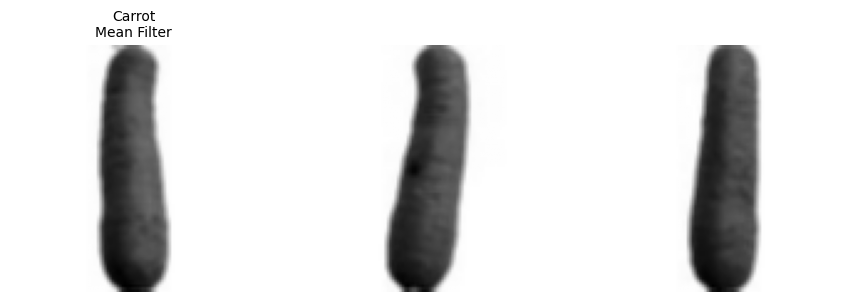

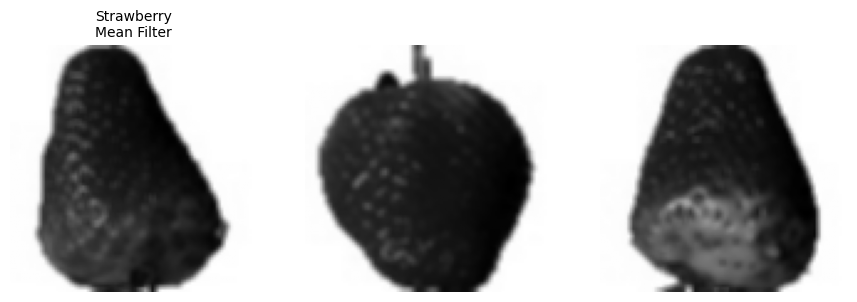

In [ ]:
visualize_mean_filter(X_train_mean, y_train, class_names, img_size, samples_per_class=3)

In [ ]:
def visualize_gaussian_filter(X_gaussian, y, class_names, img_size=(100,100), samples_per_class=3):
    """
    Visualize Gaussian-blurred images for all classes.
    """
    for label, class_name in enumerate(class_names):
        indices = np.where(y == label)[0][:samples_per_class]
        plt.figure(figsize=(samples_per_class*3, 3))

        for i, idx in enumerate(indices):
            img_array = X_gaussian[idx].reshape(img_size[1], img_size[0])
            plt.subplot(1, samples_per_class, i+1)
            plt.imshow(img_array, cmap='gray')
            plt.axis('off')
            if i == 0: plt.title(f"{class_name}\nGaussian Blur", fontsize=10)

        plt.tight_layout()
        plt.show()


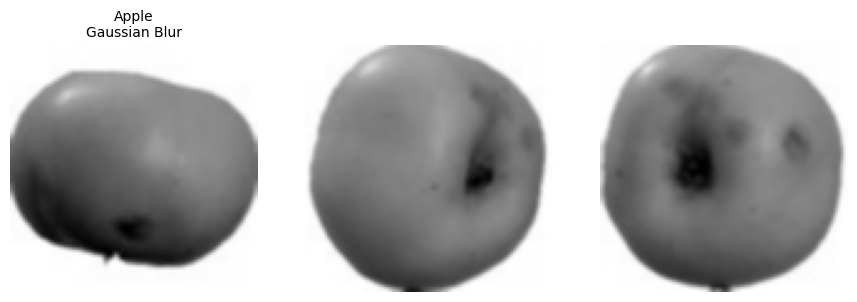

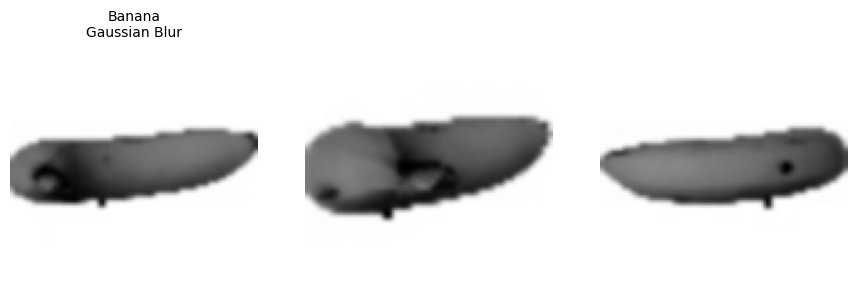

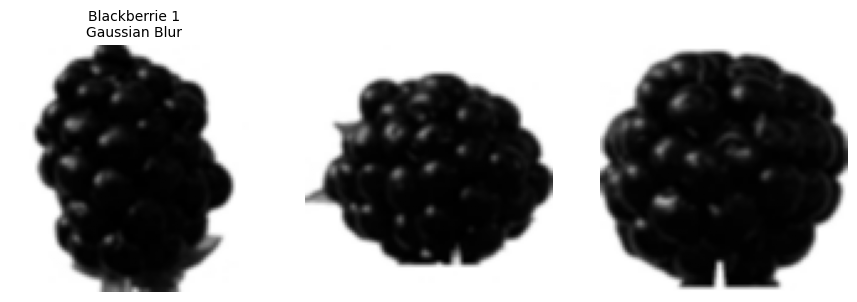

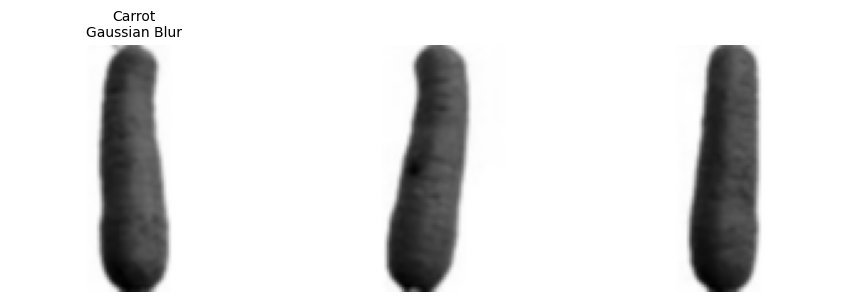

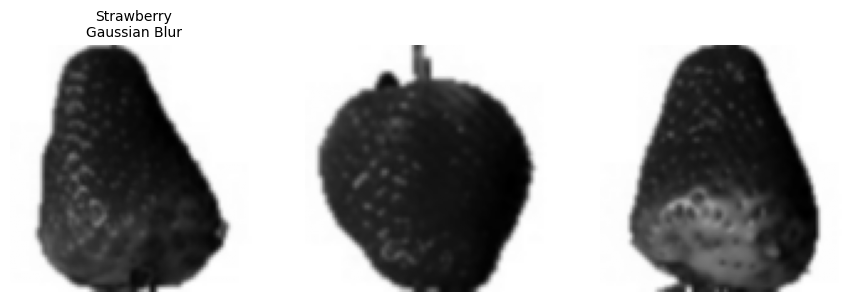

In [ ]:
visualize_gaussian_filter(X_train_gaussian, y_train, class_names, img_size, samples_per_class=3)

In [ ]:
def visualize_median_filter(X_median, y, class_names, img_size=(100,100), samples_per_class=3):
    """
    Visualize Median-filtered images for all classes.
    """
    for label, class_name in enumerate(class_names):
        indices = np.where(y == label)[0][:samples_per_class]
        plt.figure(figsize=(samples_per_class*3, 3))

        for i, idx in enumerate(indices):
            img_array = X_median[idx].reshape(img_size[1], img_size[0])
            plt.subplot(1, samples_per_class, i+1)
            plt.imshow(img_array, cmap='gray')
            plt.axis('off')
            if i == 0: plt.title(f"{class_name}\nMedian Filter", fontsize=10)

        plt.tight_layout()
        plt.show()


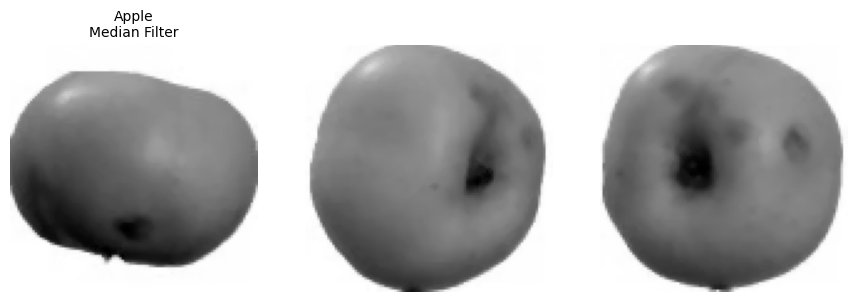

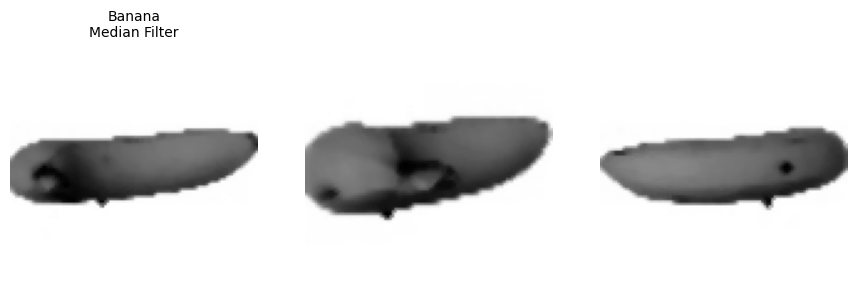

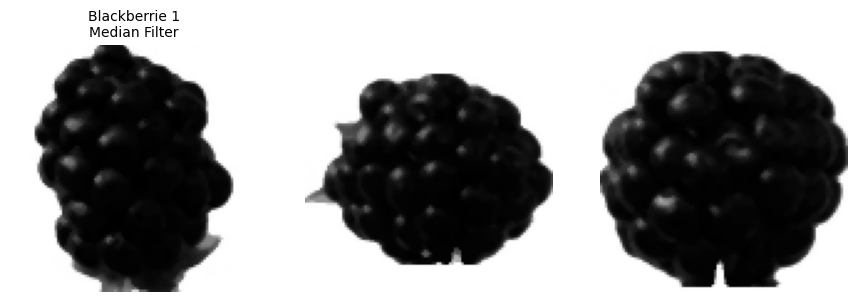

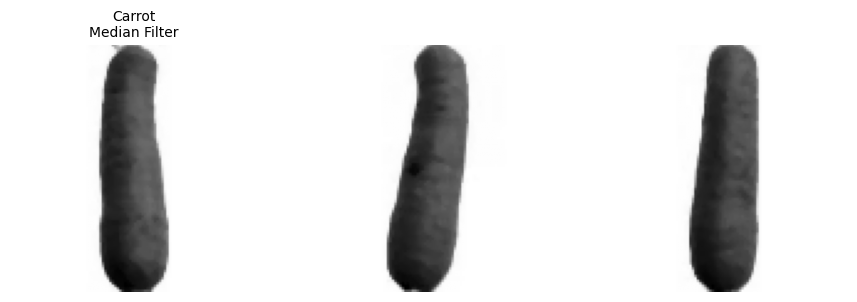

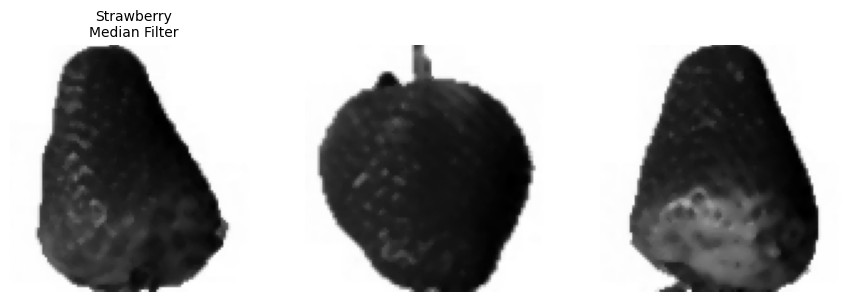

In [ ]:
visualize_median_filter(X_train_median, y_train, class_names, img_size, samples_per_class=3)

##sobel

In [ ]:
def sobel(X_gray, img_size=(100,100)):
    """
    Apply Sobel X and Y to all images and scale to 0–255 for clear visualization.
    """
    X_sobel_x = []
    X_sobel_y = []

    for img_flat in X_gray:
        img = img_flat.reshape(img_size[1], img_size[0])

        # Convert to uint8
        img_uint8 = np.uint8(img * 255) if img.max() <= 1.0 else img.astype(np.uint8)

        # Sobel X and Y
        sobelx = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)

        # Convert to 0–255 uint8 for display
        sobelx_disp = cv2.convertScaleAbs(sobelx)
        sobely_disp = cv2.convertScaleAbs(sobely)

        X_sobel_x.append(sobelx_disp)
        X_sobel_y.append(sobely_disp)

    return np.array(X_sobel_x), np.array(X_sobel_y)


In [ ]:
X_train_sobel_x, X_train_sobel_y = sobel(X_train_gray_norm, img_size)

In [ ]:
def visualize_sobel_per_class(X_sobel_x, X_sobel_y, y, class_names, img_size=(100,100), samples_per_class=3):
    """
    Visualize Sobel X and Y for multiple samples per class.
    """
    for label, class_name in enumerate(class_names):
        indices = np.where(y == label)[0][:samples_per_class]

        # Sobel X
        plt.figure(figsize=(samples_per_class*3, 3))
        for i, idx in enumerate(indices):
            plt.subplot(1, samples_per_class, i+1)
            plt.imshow(X_sobel_x[idx], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(f"{class_name}\nSobel X", fontsize=10)
        plt.tight_layout()
        plt.show()

        # Sobel Y
        plt.figure(figsize=(samples_per_class*3, 3))
        for i, idx in enumerate(indices):
            plt.subplot(1, samples_per_class, i+1)
            plt.imshow(X_sobel_y[idx], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(f"{class_name}\nSobel Y", fontsize=10)
        plt.tight_layout()
        plt.show()


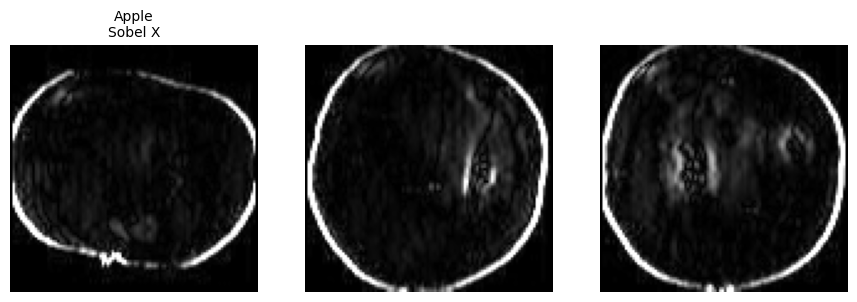

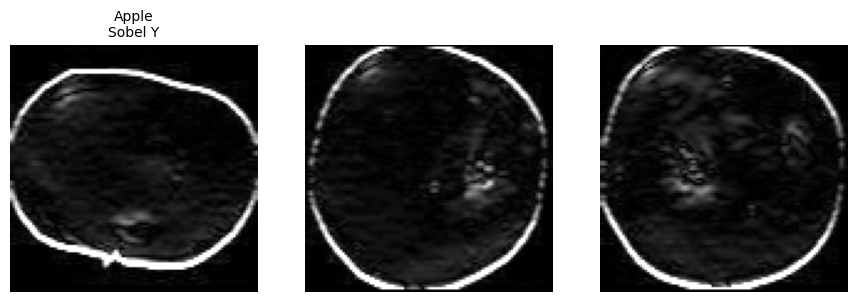

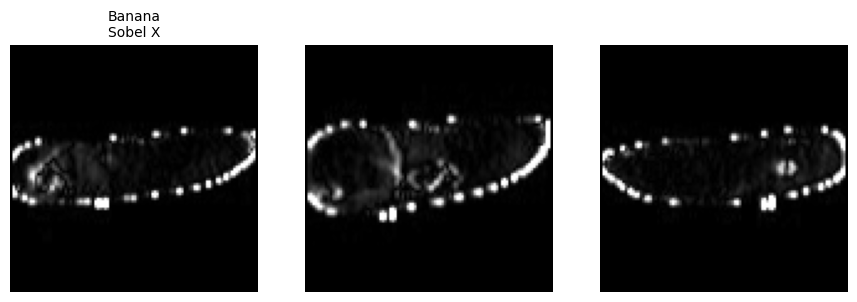

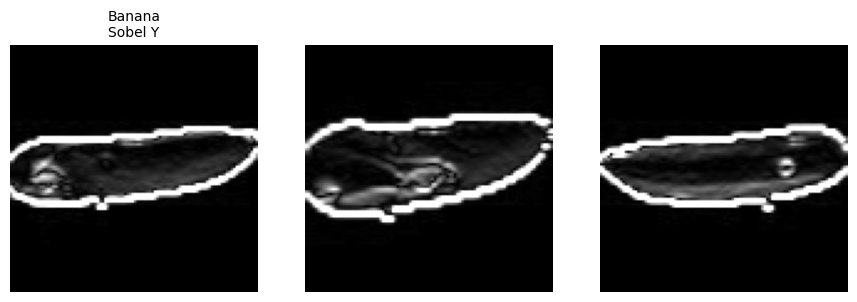

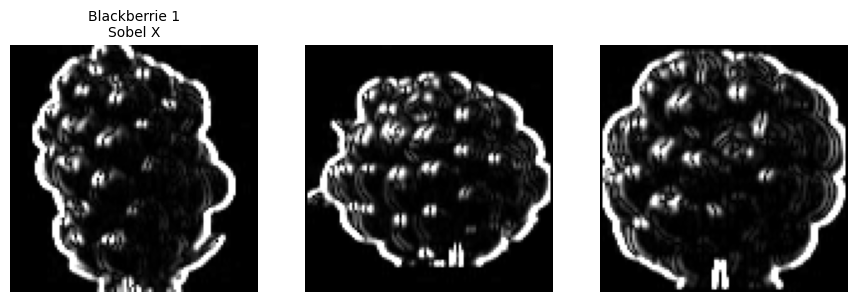

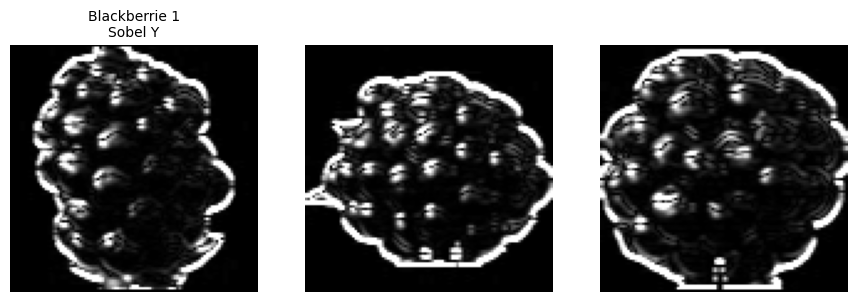

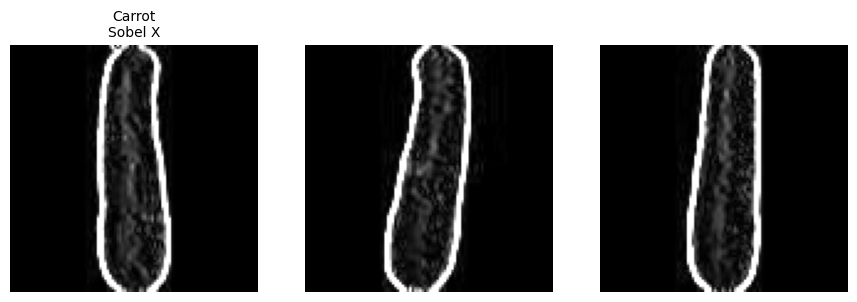

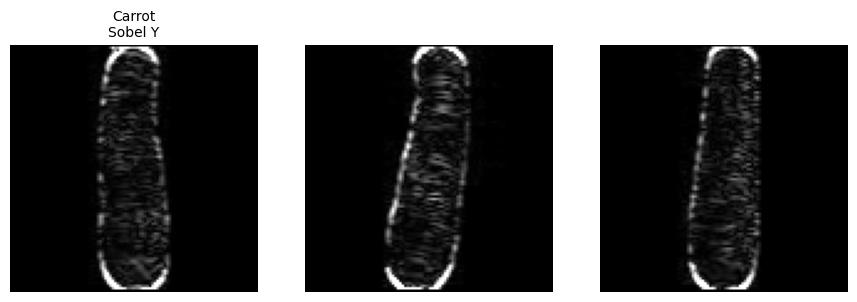

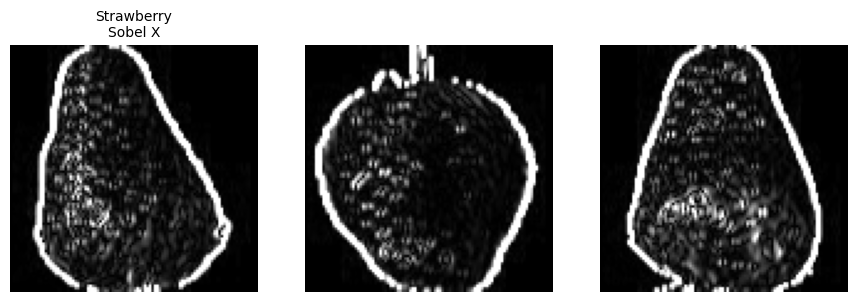

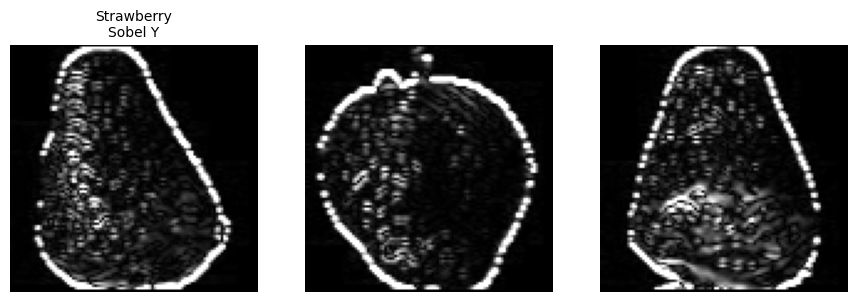

In [ ]:
visualize_sobel_per_class(
    X_train_sobel_x, X_train_sobel_y,
    y_train, class_names,
    img_size=img_size,
    samples_per_class=3
)


##La placian filter

In [ ]:
def apply_laplacian_filter(X_gray, img_size=(100,100)):
    """
    Apply Laplacian filter to all grayscale images.
    """
    X_laplacian = []

    for img_flat in X_gray:
        img = img_flat.reshape(img_size[1], img_size[0])
        img_uint8 = np.uint8(img*255) if img.max() <= 1.0 else img.astype(np.uint8)

        # Apply Laplacian
        laplacian = cv2.Laplacian(img_uint8, cv2.CV_64F)
        laplacian_disp = cv2.convertScaleAbs(laplacian)  # scale to 0-255

        X_laplacian.append(laplacian_disp)

    return np.array(X_laplacian)

# Apply to training set
X_train_laplacian = apply_laplacian_filter(X_train_gray_norm, img_size)
X_test_laplacian = apply_laplacian_filter(X_test_gray_norm, img_size)


In [ ]:
def visualize_laplacian_per_class(X_laplacian, y, class_names, img_size=(100,100), samples_per_class=3):
    """
    Visualize Laplacian-filtered images for all classes.
    """
    for label, class_name in enumerate(class_names):
        indices = np.where(y == label)[0][:samples_per_class]
        plt.figure(figsize=(samples_per_class*3, 3))

        for i, idx in enumerate(indices):
            plt.subplot(1, samples_per_class, i+1)
            plt.imshow(X_laplacian[idx], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(f"{class_name}\nLaplacian", fontsize=10)

        plt.tight_layout()
        plt.show()


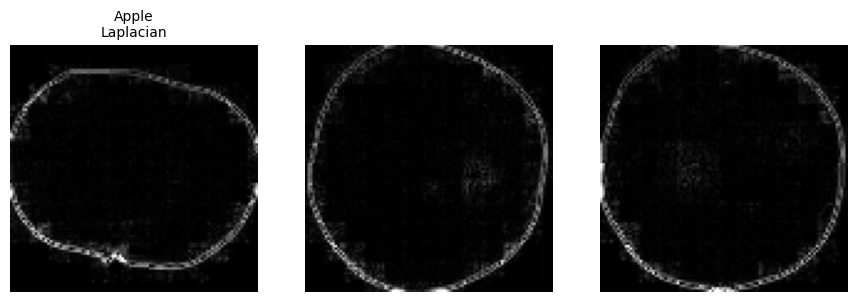

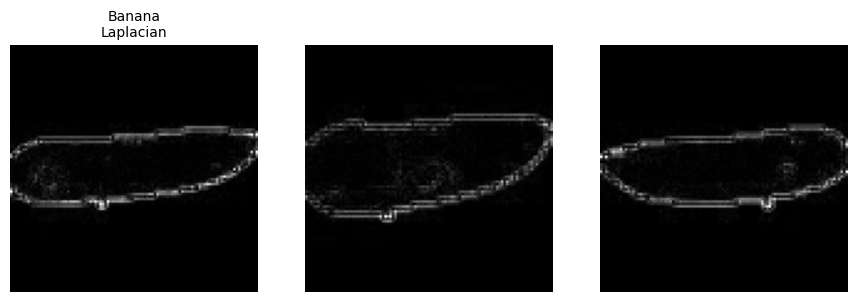

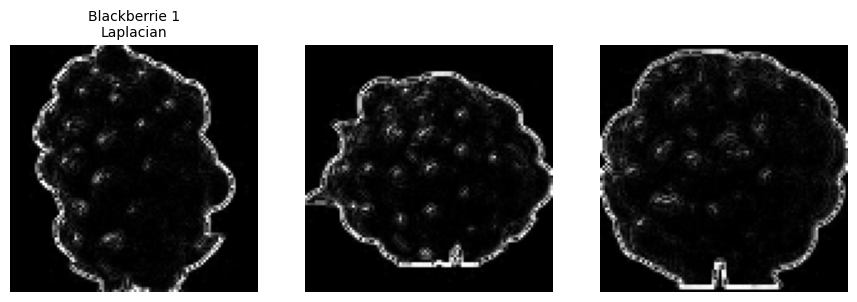

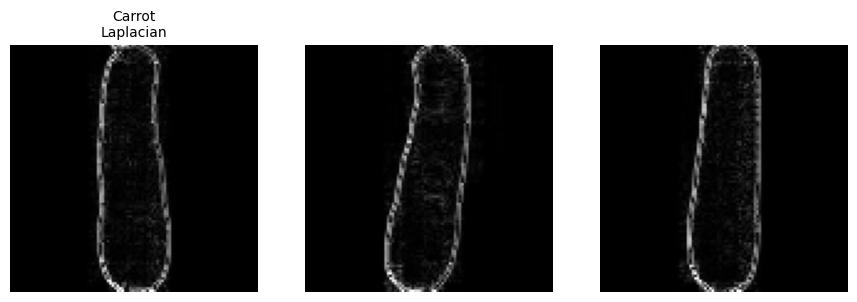

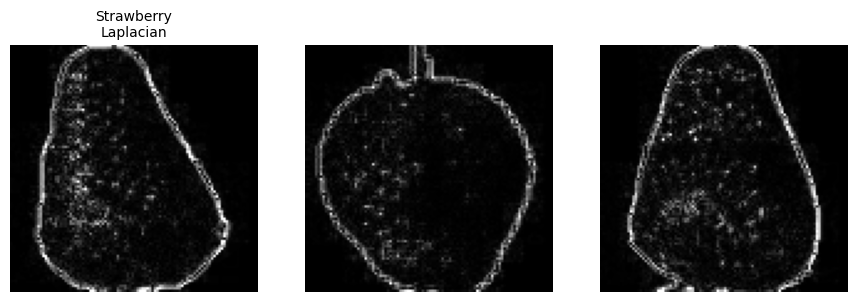

In [ ]:
visualize_laplacian_per_class(
    X_train_laplacian, y_train, class_names,
    img_size=img_size, samples_per_class=3
)


##sharpening filter

In [ ]:
sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
], dtype=np.float32)

def apply_sharpening_filter(X_gray, img_size=(100,100)):
    """
    Apply sharpening filter to grayscale images using a custom kernel.
    """
    X_sharpened = []

    for img_flat in X_gray:
        img = img_flat.reshape(img_size[1], img_size[0])
        img_uint8 = np.uint8(img * 255) if img.max() <= 1.0 else img.astype(np.uint8)

        # Apply sharpening using convolution
        sharpened = cv2.filter2D(img_uint8, ddepth=-1, kernel=sharpen_kernel)
        X_sharpened.append(sharpened)

    return np.array(X_sharpened)


X_train_sharpened = apply_sharpening_filter(X_train_gray_norm, img_size)
X_test_sharpened = apply_sharpening_filter(X_test_gray_norm, img_size)


In [ ]:
def visualize_sharpened_per_class(X_sharpened, y, class_names, img_size=(100,100), samples_per_class=3):
    """
    Visualize sharpened images for all classes.
    """
    for label, class_name in enumerate(class_names):
        indices = np.where(y == label)[0][:samples_per_class]
        plt.figure(figsize=(samples_per_class*3, 3))

        for i, idx in enumerate(indices):
            plt.subplot(1, samples_per_class, i+1)
            plt.imshow(X_sharpened[idx], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(f"{class_name}\nSharpened", fontsize=10)

        plt.tight_layout()
        plt.show()


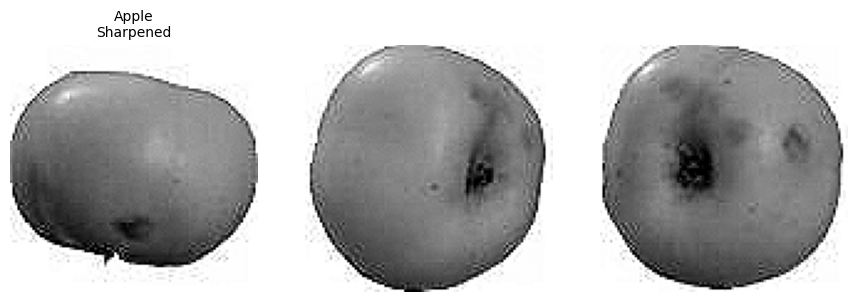

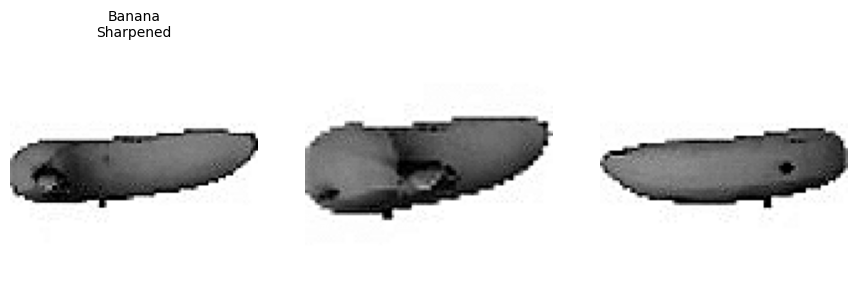

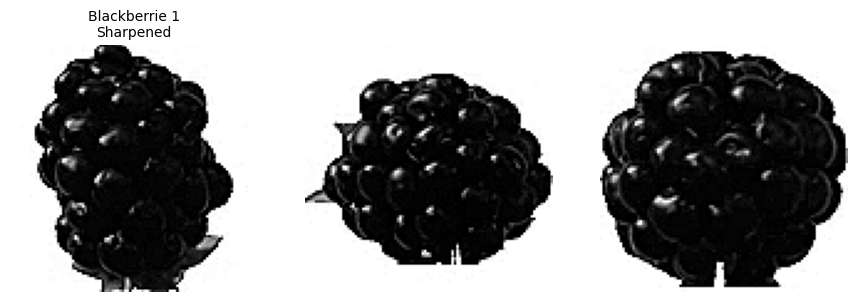

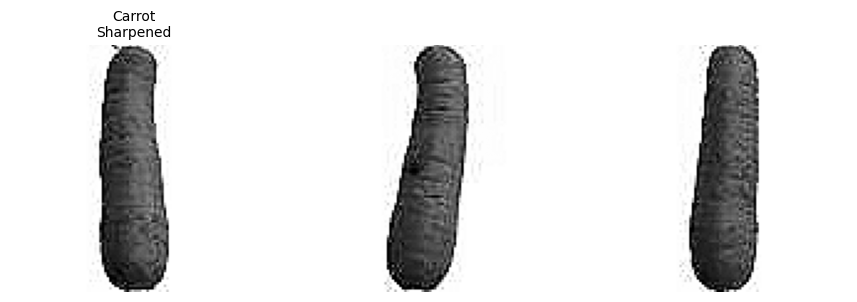

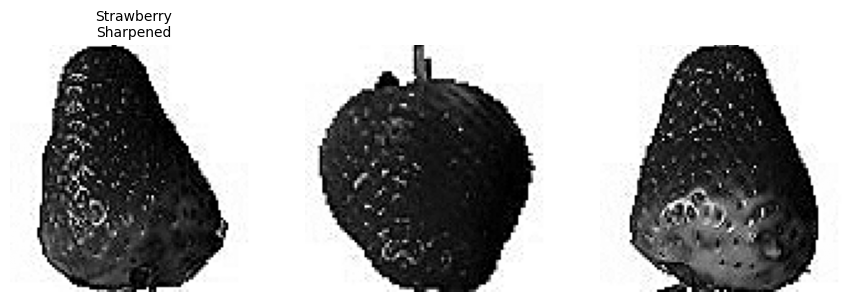

In [ ]:
visualize_sharpened_per_class(
    X_train_sharpened, y_train, class_names,
    img_size=img_size, samples_per_class=3
)


##Segmentation with thresholding

In [ ]:
def apply_binary_threshold(X_gray, threshold=127, img_size=(100,100)):
    """
    Apply binary thresholding to a set of grayscale images.
    """
    X_binary = []

    for img_flat in X_gray:
        img = img_flat.reshape(img_size[1], img_size[0])
        img_uint8 = np.uint8(img * 255) if img.max() <= 1.0 else img.astype(np.uint8)

        # Apply binary threshold
        _, binary_img = cv2.threshold(img_uint8, threshold, 255, cv2.THRESH_BINARY)
        X_binary.append(binary_img)

    return np.array(X_binary)

# Apply to training and test sets
X_train_binary = apply_binary_threshold(X_train_gray_norm, threshold=127, img_size=img_size)
X_test_binary = apply_binary_threshold(X_test_gray_norm, threshold=127, img_size=img_size)


In [ ]:
def visualize_binary_per_class(X_binary, y, class_names, img_size=(100,100), samples_per_class=3):
    """
    Visualize thresholded binary images for all classes.
    """
    for label, class_name in enumerate(class_names):
        indices = np.where(y == label)[0][:samples_per_class]
        plt.figure(figsize=(samples_per_class*3, 3))

        for i, idx in enumerate(indices):
            plt.subplot(1, samples_per_class, i+1)
            plt.imshow(X_binary[idx], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(f"{class_name}\nBinary Threshold", fontsize=10)

        plt.tight_layout()
        plt.show()


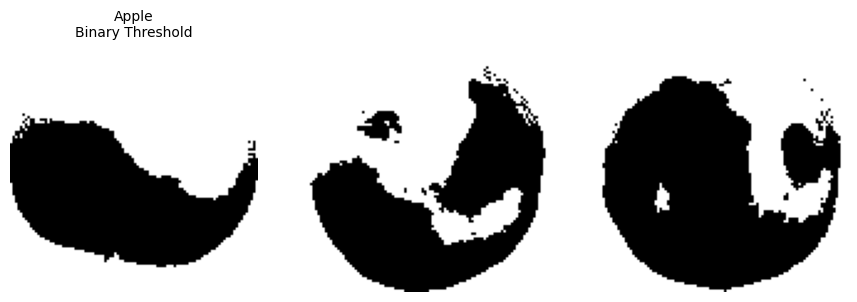

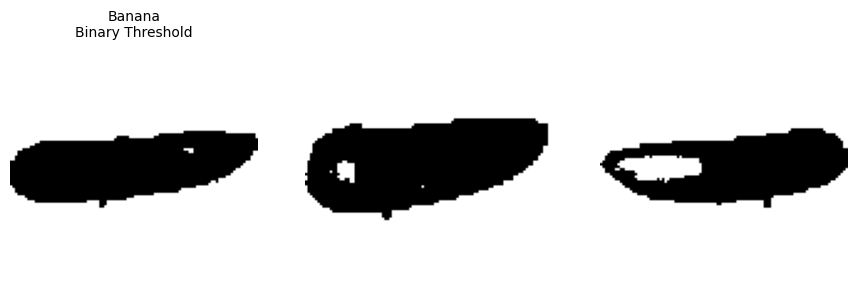

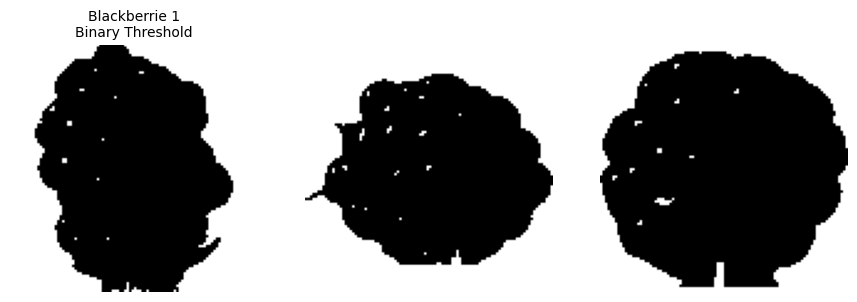

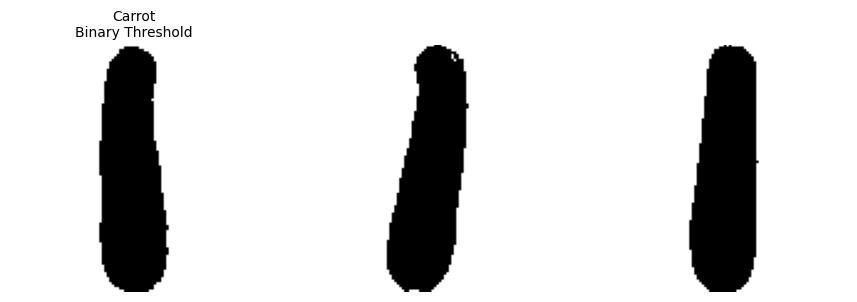

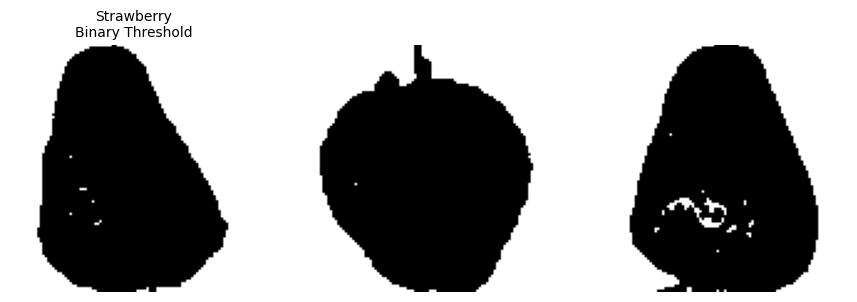

In [ ]:
visualize_binary_per_class(
    X_train_binary, y_train, class_names,
    img_size=img_size, samples_per_class=3
)


##adaptive thresholding

In [ ]:
def apply_adaptive_threshold(X_gray, img_size=(100,100), block_size=11, C=2):
    """
    Apply adaptive mean thresholding to grayscale images.
    """
    X_adaptive = []

    for img_flat in X_gray:
        img = img_flat.reshape(img_size[1], img_size[0])
        img_uint8 = np.uint8(img * 255) if img.max() <= 1.0 else img.astype(np.uint8)

        # Adaptive threshold
        adaptive_img = cv2.adaptiveThreshold(
            img_uint8,
            maxValue=255,
            adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
            thresholdType=cv2.THRESH_BINARY,
            blockSize=block_size,
            C=C
        )
        X_adaptive.append(adaptive_img)

    return np.array(X_adaptive)

# Apply to training and test sets
X_train_adaptive = apply_adaptive_threshold(X_train_gray_norm, img_size=img_size)
X_test_adaptive = apply_adaptive_threshold(X_test_gray_norm, img_size=img_size)


In [ ]:
def visualize_adaptive_per_class(X_adaptive, y, class_names, img_size=(100,100), samples_per_class=3):
    """
    Visualize adaptive thresholded images for all classes.
    """
    for label, class_name in enumerate(class_names):
        indices = np.where(y == label)[0][:samples_per_class]
        plt.figure(figsize=(samples_per_class*3, 3))

        for i, idx in enumerate(indices):
            plt.subplot(1, samples_per_class, i+1)
            plt.imshow(X_adaptive[idx], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(f"{class_name}\nAdaptive Threshold", fontsize=10)

        plt.tight_layout()
        plt.show()


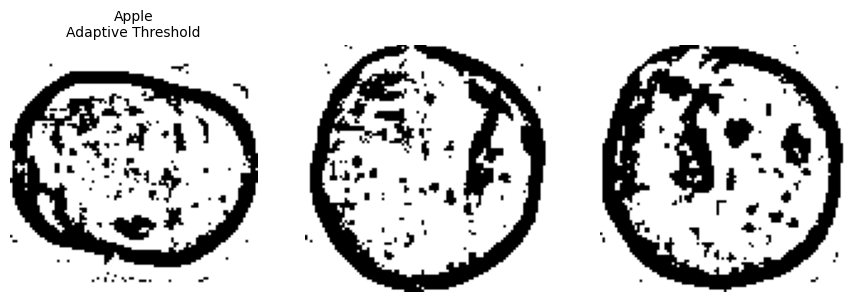

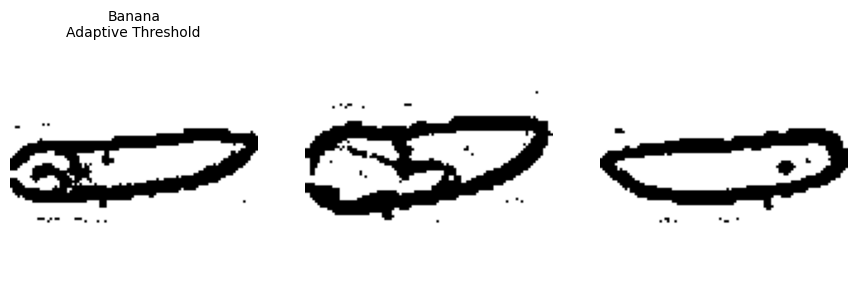

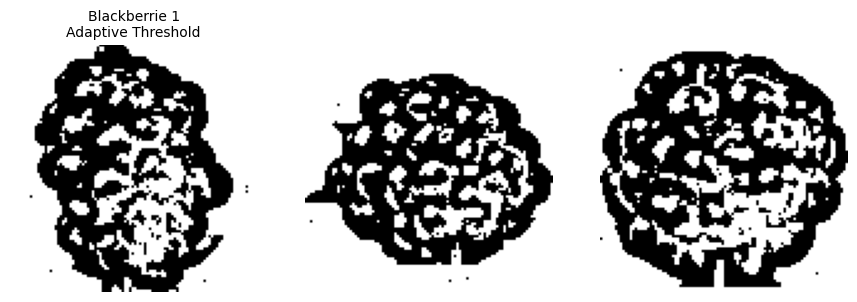

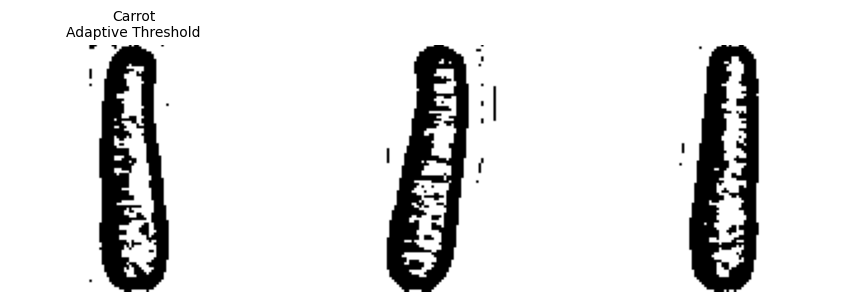

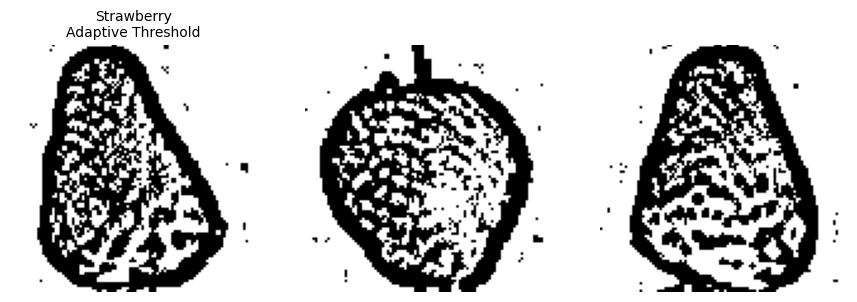

In [ ]:
visualize_adaptive_per_class(
    X_train_adaptive, y_train, class_names,
    img_size=img_size, samples_per_class=3
)


## otsu's thresholding

In [ ]:
def apply_otsu_threshold(X_gray, img_size=(100,100)):
    """
    Apply Otsu's thresholding to a set of grayscale images.
    """
    X_otsu = []

    for img_flat in X_gray:
        img = img_flat.reshape(img_size[1], img_size[0])
        img_uint8 = np.uint8(img*255) if img.max() <= 1.0 else img.astype(np.uint8)

        # Otsu's thresholding
        _, otsu_img = cv2.threshold(img_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        X_otsu.append(otsu_img)

    return np.array(X_otsu)

# Apply to training and test sets
X_train_otsu = apply_otsu_threshold(X_train_gray_norm, img_size)
X_test_otsu = apply_otsu_threshold(X_test_gray_norm, img_size)


In [ ]:
def visualize_otsu_per_class(X_otsu, y, class_names, img_size=(100,100), samples_per_class=3):
    """
    Visualize Otsu thresholded images for all classes.
    """
    for label, class_name in enumerate(class_names):
        indices = np.where(y == label)[0][:samples_per_class]
        plt.figure(figsize=(samples_per_class*3, 3))

        for i, idx in enumerate(indices):
            plt.subplot(1, samples_per_class, i+1)
            plt.imshow(X_otsu[idx], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(f"{class_name}\nOtsu Threshold", fontsize=10)

        plt.tight_layout()
        plt.show()


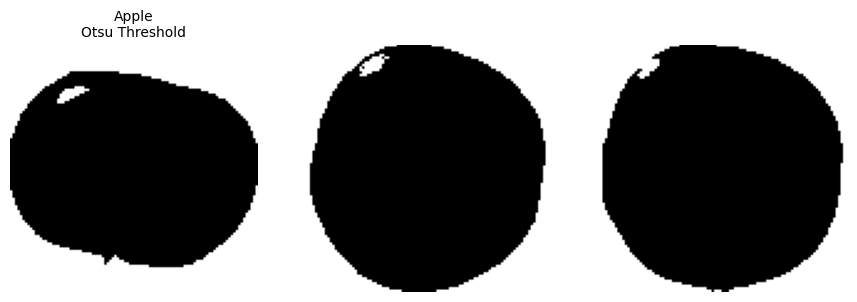

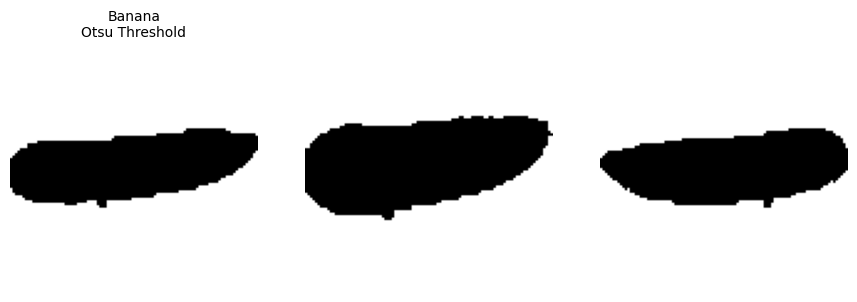

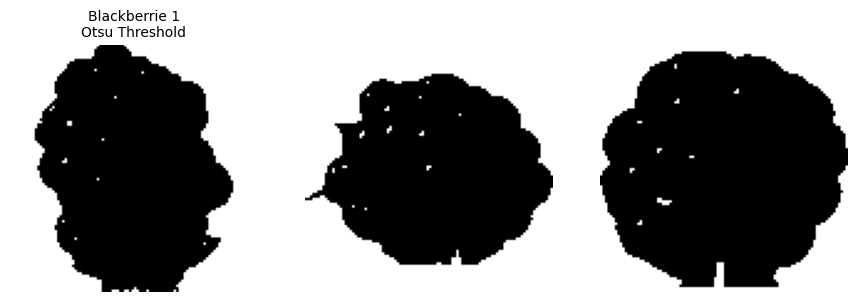

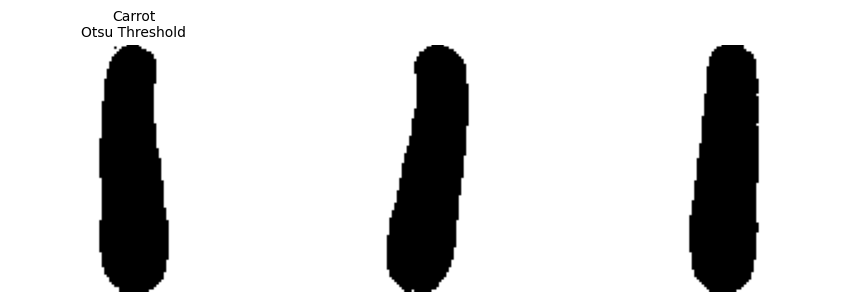

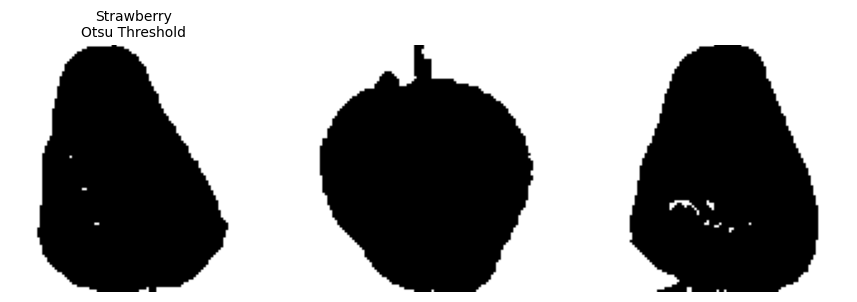

In [ ]:
visualize_otsu_per_class(
    X_train_otsu, y_train, class_names,
    img_size=img_size, samples_per_class=3
)


### LOGISTIC REGRESSION MODEL

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy: 0.9461

Classification Report:

               precision    recall  f1-score   support

        Apple       1.00      1.00      1.00       157
       Banana       0.94      0.87      0.90       166
Blackberrie 1       0.96      1.00      0.98       150
       Carrot       0.69      1.00      0.82        50
   Strawberry       1.00      0.91      0.95       164

     accuracy                           0.95       687
    macro avg       0.92      0.96      0.93       687
 weighted avg       0.96      0.95      0.95       687



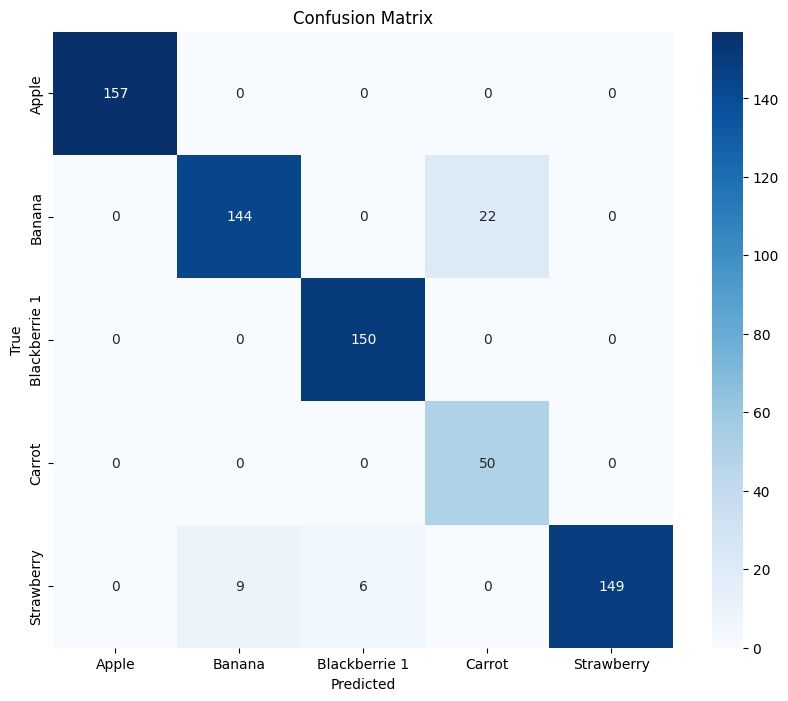

In [ ]:
def run_logistic_regression(X_train_pre, X_test_pre, y_train, y_test, class_names):
    """
    Full logistic regression pipeline:
    1. Flatten images if needed
    2. Standardize features
    3. Train multinomial logistic regression
    4. Evaluate accuracy, classification report, confusion matrix
    """

    # Flatten images if 3D
    if X_train_pre.ndim > 2:
        X_train_flat = X_train_pre.reshape(X_train_pre.shape[0], -1)
        X_test_flat = X_test_pre.reshape(X_test_pre.shape[0], -1)
    else:
        X_train_flat = X_train_pre
        X_test_flat = X_test_pre

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)

    # Train logistic regression
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000
    )
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.4f}")

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return model, scaler

# ===============================
# Example Usage
# ===============================

# You can choose any preprocessed dataset, e.g.,
# X_train_gray_norm, X_train_eq, X_train_laplacian, etc.
# Here, we use normalized grayscale:
model, scaler = run_logistic_regression(
    X_train_gray_norm,
    X_test_gray_norm,
    y_train,
    y_test,
    class_names
)


###K MEANS


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.optimize import linear_sum_assignment # Import for optimal mapping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def kmeans_pipeline_full(X_train_dict, X_test_dict, y_train, y_test, class_names):
    results = {}

    # Helper: flatten and normalize dataset if needed
    def preprocess_dataset(X):
        if X.ndim > 2:  # multi-channel or HxW
            X_flat = X.reshape(X.shape[0], -1)
        else:
            X_flat = X
        # Normalize if pixel values are >1 (assuming uint8 or similar initially)
        if np.max(X_flat) > 1 and np.issubdtype(X_flat.dtype, np.integer):
            X_flat = X_flat / 255.0
        return X_flat

    # Helper: map KMeans clusters to true labels using optimal assignment
    def map_clusters_to_labels(clusters, y_true):
        num_clusters = len(np.unique(clusters))
        num_true_labels = len(np.unique(y_true)) # This should be len(class_names)

        # Create a contingency matrix: entry (i, j) is count of true label j in cluster i
        contingency_matrix = np.zeros((num_clusters, num_true_labels), dtype=int)
        for i in range(num_clusters):
            # Get true labels for samples in cluster i
            true_labels_in_cluster = y_true[clusters == i]
            for j in range(num_true_labels):
                contingency_matrix[i, j] = np.sum(true_labels_in_cluster == j)

        # Use Hungarian algorithm to find optimal assignment
        # We want to maximize matches, so minimize the negative counts
        row_ind, col_ind = linear_sum_assignment(-contingency_matrix)

        # Create the mapping from cluster_id to true_label
        # `row_ind` are cluster_ids, `col_ind` are true_labels
        cluster_to_true_label_map = np.full(num_clusters, -1, dtype=int)
        for r, c in zip(row_ind, col_ind):
            cluster_to_true_label_map[r] = c

        # Apply the mapping to the cluster assignments
        mapped_labels = np.array([cluster_to_true_label_map[c] for c in clusters])
        return mapped_labels

    # Iterate over datasets
    for name, X_train in X_train_dict.items():
        X_train_flat = preprocess_dataset(X_train)
        X_test_flat = preprocess_dataset(X_test_dict[name])

        # K-Means
        kmeans = KMeans(n_clusters=len(class_names), random_state=42, n_init=10)
        kmeans.fit(X_train_flat)
        train_clusters = kmeans.labels_
        y_train_mapped = map_clusters_to_labels(train_clusters, y_train)

        # Training metrics
        train_acc = accuracy_score(y_train, y_train_mapped)
        print(f"\n=== {name} ===")
        print(f"Training Accuracy: {train_acc:.4f}")
        print("\nClassification Report:\n")
        # Set zero_division to 0 to prevent warnings and consistently report 0 for unpredicted classes
        print(classification_report(y_train, y_train_mapped, target_names=class_names, zero_division=0))

        # Confusion matrix
        cm = confusion_matrix(y_train, y_train_mapped)
        plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
        plt.xlabel("Predicted Cluster Label")
        plt.ylabel("True Class Label")
        plt.title(f"K-Means Confusion Matrix ({name})")
        plt.show()

        # Test metrics
        test_clusters = kmeans.predict(X_test_flat)
        y_test_mapped = map_clusters_to_labels(test_clusters, y_test)
        test_acc = accuracy_score(y_test, y_test_mapped)
        print(f"Test Accuracy: {test_acc:.4f}")

        results[name] = {"train_acc": train_acc, "test_acc": test_acc}

    return results

In [ ]:
X_train_otsu_norm = X_train_otsu / 255.0
X_test_otsu_norm = X_test_otsu / 255.0

In [ ]:
# Example: combining Sobel X and Y if needed
X_train_sobel_x, X_train_sobel_y = sobel(X_train_gray_norm, img_size)
X_test_sobel_x, X_test_sobel_y = sobel(X_test_gray_norm, img_size)
X_train_sobel_combined = np.stack([X_train_sobel_x, X_train_sobel_y], axis=-1)
X_test_sobel_combined = np.stack([X_test_sobel_x, X_test_sobel_y], axis=-1)

X_train_dict = {
    "Grayscale": X_train_gray_norm,
    "Histogram_Equalized": X_train_eq,
    "Laplacian": X_train_laplacian,
    "Sobel": X_train_sobel_combined,            # now using the combined variable
    "Sharpened": X_train_sharpened,
    "Otsu": X_train_otsu_norm
}

X_test_dict = {
    "Grayscale": X_test_gray_norm,
    "Histogram_Equalized": X_test_eq,
    "Laplacian": X_test_laplacian,
    "Sobel": X_test_sobel_combined,             # now using the combined variable
    "Sharpened": X_test_sharpened,
    "Otsu": X_test_otsu_norm
}


=== Grayscale ===
Training Accuracy: 0.7111

Classification Report:

               precision    recall  f1-score   support

        Apple       0.80      1.00      0.89       473
       Banana       0.81      0.75      0.78       490
Blackberrie 1       0.47      0.50      0.48       450
       Carrot       1.00      1.00      1.00       151
   Strawberry       0.64      0.50      0.56       492

     accuracy                           0.71      2056
    macro avg       0.74      0.75      0.74      2056
 weighted avg       0.71      0.71      0.70      2056



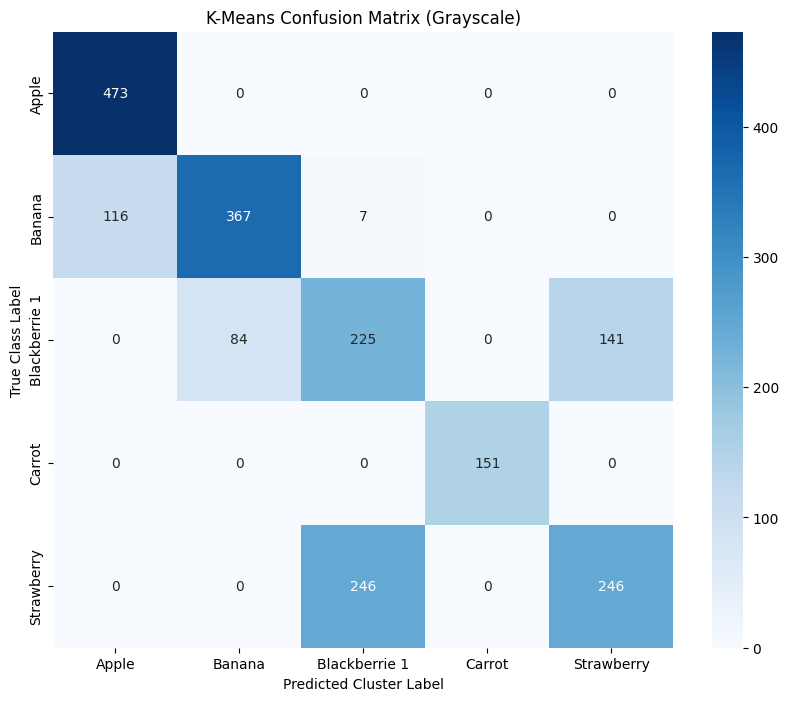

Test Accuracy: 0.6769

=== Histogram_Equalized ===
Training Accuracy: 0.5798

Classification Report:

               precision    recall  f1-score   support

        Apple       0.56      1.00      0.72       473
       Banana       1.00      0.39      0.56       490
Blackberrie 1       0.33      0.27      0.30       450
       Carrot       1.00      1.00      1.00       151
   Strawberry       0.51      0.52      0.52       492

     accuracy                           0.58      2056
    macro avg       0.68      0.64      0.62      2056
 weighted avg       0.64      0.58      0.56      2056



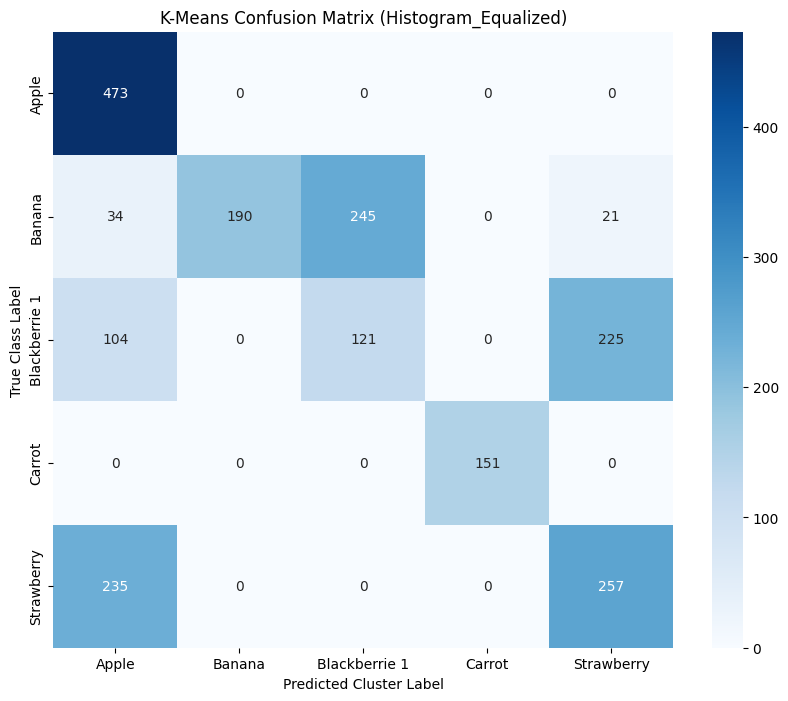

Test Accuracy: 0.5415

=== Laplacian ===
Training Accuracy: 0.7446

Classification Report:

               precision    recall  f1-score   support

        Apple       0.63      1.00      0.77       473
       Banana       0.64      0.89      0.75       490
Blackberrie 1       1.00      0.50      0.67       450
       Carrot       1.00      1.00      1.00       151
   Strawberry       1.00      0.50      0.67       492

     accuracy                           0.74      2056
    macro avg       0.85      0.78      0.77      2056
 weighted avg       0.83      0.74      0.73      2056



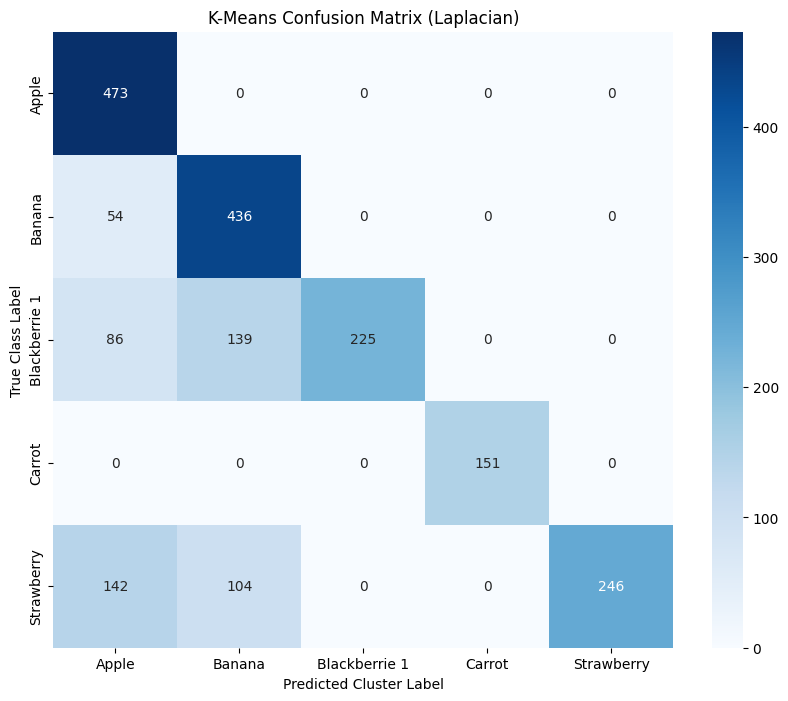

Test Accuracy: 0.7715

=== Sobel ===
Training Accuracy: 0.7125

Classification Report:

               precision    recall  f1-score   support

        Apple       0.83      1.00      0.91       473
       Banana       0.78      0.76      0.77       490
Blackberrie 1       0.97      0.50      0.66       450
       Carrot       0.35      1.00      0.52       151
   Strawberry       0.70      0.50      0.58       492

     accuracy                           0.71      2056
    macro avg       0.73      0.75      0.69      2056
 weighted avg       0.78      0.71      0.71      2056



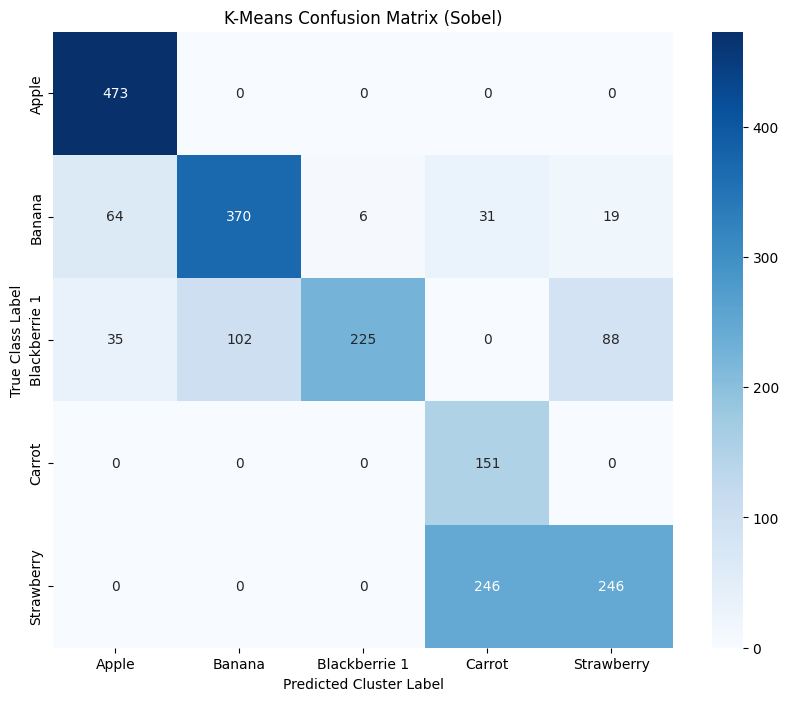

Test Accuracy: 0.6274

=== Sharpened ===
Training Accuracy: 0.7116

Classification Report:

               precision    recall  f1-score   support

        Apple       0.80      1.00      0.89       473
       Banana       0.81      0.75      0.78       490
Blackberrie 1       0.47      0.50      0.48       450
       Carrot       1.00      1.00      1.00       151
   Strawberry       0.64      0.50      0.56       492

     accuracy                           0.71      2056
    macro avg       0.74      0.75      0.74      2056
 weighted avg       0.71      0.71      0.70      2056



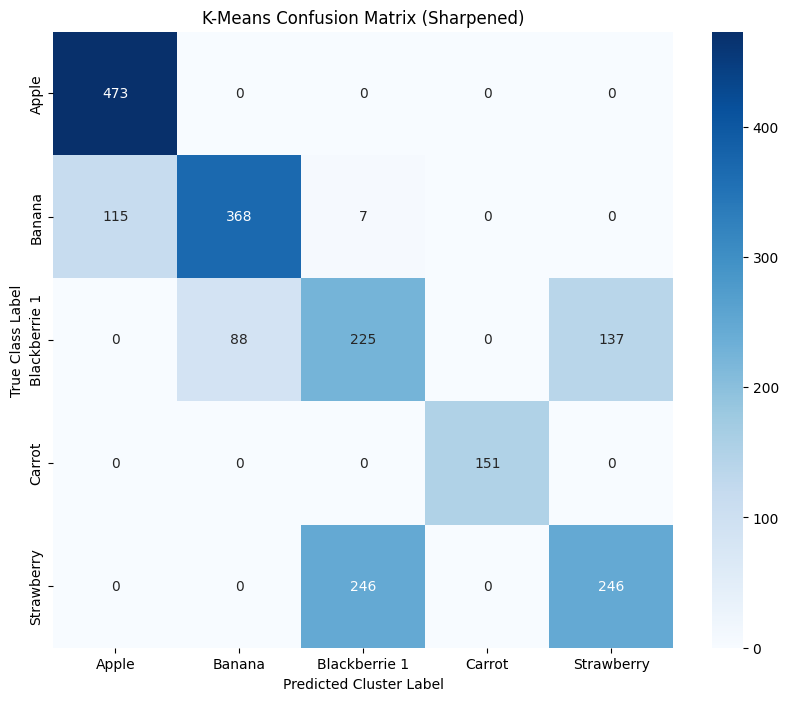

Test Accuracy: 0.6769

=== Otsu ===
Training Accuracy: 0.5793

Classification Report:

               precision    recall  f1-score   support

        Apple       0.61      0.94      0.74       473
       Banana       1.00      0.44      0.61       490
Blackberrie 1       0.29      0.27      0.28       450
       Carrot       1.00      1.00      1.00       151
   Strawberry       0.48      0.53      0.50       492

     accuracy                           0.58      2056
    macro avg       0.68      0.63      0.63      2056
 weighted avg       0.63      0.58      0.57      2056



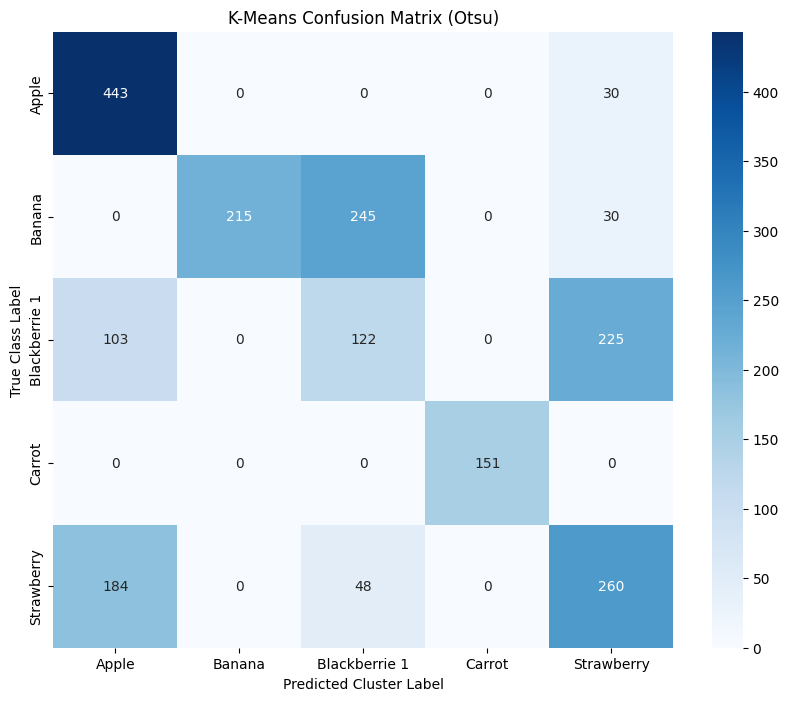

Test Accuracy: 0.5284
Grayscale: Train Accuracy = 0.7111, Test Accuracy = 0.6769
Histogram_Equalized: Train Accuracy = 0.5798, Test Accuracy = 0.5415
Laplacian: Train Accuracy = 0.7446, Test Accuracy = 0.7715
Sobel: Train Accuracy = 0.7125, Test Accuracy = 0.6274
Sharpened: Train Accuracy = 0.7116, Test Accuracy = 0.6769
Otsu: Train Accuracy = 0.5793, Test Accuracy = 0.5284


In [ ]:
results = kmeans_pipeline_full(
    X_train_dict, X_test_dict,
    y_train, y_test,
    class_names
)

# Summary of results
for name, res in results.items():
    print(f"{name}: Train Accuracy = {res['train_acc']:.4f}, Test Accuracy = {res['test_acc']:.4f}")


# Task
Let's delve into the fundamental differences between K-Means (an unsupervised learning algorithm) and Logistic Regression (a supervised learning algorithm) in the context of classification tasks. This will help clarify why K-Means, despite being useful for clustering, is not ideally suited for direct classification, especially when labeled data is available.

### K-Means (Unsupervised Learning)

**Purpose**: K-Means is a clustering algorithm. Its primary goal is to group similar data points together into a predefined number of clusters (K). It does this by finding centroids (mean of the data points) for each cluster and assigning each data point to the closest centroid.

**Key Characteristics**:
*   **No Labels Required**: K-Means operates on unlabeled data. It discovers inherent structures or groupings within the data without any prior knowledge of categories.
*   **Discovery of Structure**: It's excellent for exploratory data analysis, segmenting customer bases, or identifying natural groupings in datasets.
*   **Output**: The output of K-Means is a cluster assignment for each data point. These assignments are arbitrary numerical labels (e.g., 0, 1, 2) that do not inherently correspond to meaningful real-world categories unless manually mapped.
*   **Limitations for Classification**:
    *   **No Direct Mapping to Classes**: Even if clusters align perfectly with actual classes, the cluster labels (e.g., 0, 1) are arbitrary and don't automatically mean "Apple" or "Banana." A post-hoc mapping step (like the one we implemented using the Hungarian algorithm) is always required to assign real class names to clusters, and this mapping is based on how well the clusters match the true labels in the training set.
    *   **Optimizes for Compactness, Not Separation**: K-Means minimizes the within-cluster variance, meaning it tries to make clusters as compact as possible. It does *not* optimize for separating different classes, which is the goal of classification.
    *   **Sensitivity to Initialization**: The final clustering can be sensitive to the initial placement of centroids.
    *   **Assumes Spherical Clusters**: K-Means works best when clusters are spherical and equally sized, which is often not the case with real-world data distributions for distinct classes.

### Logistic Regression (Supervised Learning)

**Purpose**: Logistic Regression is a classification algorithm. Its primary goal is to predict the probability that a given input belongs to a certain class, based on a set of labeled training data.

**Key Characteristics**:
*   **Labels Required**: Logistic Regression requires labeled data for training. It learns a mapping from input features (like image pixels) to known output classes (like "Apple", "Banana", etc.).
*   **Direct Prediction**: It directly predicts the class membership for new, unseen data points.
*   **Optimizes for Class Separation**: The algorithm learns a decision boundary that best separates the different classes based on the provided labels.
*   **Output**: The output is a probability distribution over the classes for each data point, which can then be converted into a discrete class prediction.
*   **Advantages for Classification**:
    *   **Learns from Examples**: By training on labeled data, it learns to distinguish between classes based on features that are actually relevant to those distinctions.
    *   **Directly Applicable**: Once trained, it can directly predict the class of a new image without additional mapping steps.
    *   **Probabilistic Output**: Provides probabilities, which can be useful for understanding model confidence.

### Why Supervised Models Outperform Unsupervised Models for Classification

When labeled data is available, supervised models like Logistic Regression almost invariably outperform unsupervised models like K-Means for classification tasks because:
1.  **Direct Optimization**: Supervised models are designed and optimized explicitly to discriminate between predefined classes. They learn the features and patterns that directly lead to correct class assignments.
2.  **Utilize Label Information**: The availability of labels provides crucial guidance during the learning process, allowing the model to adjust its parameters to minimize misclassifications. K-Means, lacking this guidance, can only group data based on feature similarity, which may or may not align with the desired class boundaries.
3.  **Performance Metrics**: Supervised models are evaluated using metrics (like accuracy, precision, recall) that directly reflect their ability to classify correctly, whereas for unsupervised models applied to classification, these metrics are often achieved indirectly through a post-clustering mapping.

In our case, the K-Means models generated clusters based purely on the pixel similarities, and then we attempted to map these clusters to our known fruit categories. While some clusters might naturally correspond well to a fruit type, K-Means isn't "told" what an "Apple" looks like; it just finds groups. Logistic Regression, on the other hand, learns specifically to differentiate between "Apple," "Banana," etc., using the provided examples. This is why we expect Logistic Regression to achieve higher classification accuracy.

Now, let's run the Logistic Regression model with the optimal input (normalized grayscale images) to see its performance.

## Explain K-Means vs. Supervised Models

### Subtask:
Elaborate on the fundamental difference between unsupervised (K-Means) and supervised (Logistic Regression) models, explaining why K-Means inherently has limitations in achieving high classification accuracy.


## K-Means (Unsupervised Clustering) vs. Logistic Regression (Supervised Classification)

### Fundamental Differences

**1. Learning Paradigm:**
   - **Supervised Learning (Logistic Regression):** This paradigm involves training a model on a labeled dataset, meaning each input data point is associated with a correct output label. The model learns a mapping function from inputs to outputs based on these examples. The goal is to predict the label for new, unseen data.
   - **Unsupervised Learning (K-Means):** This paradigm deals with unlabeled data. The model is given only input data and must find patterns or structures within it without any prior knowledge of output labels. The primary goal is to group similar data points together or reduce dimensionality.

**2. Objective:**
   - **Logistic Regression:** The objective is to learn a decision boundary that accurately separates different classes in the feature space. It aims to directly predict the probability of a data point belonging to a certain class.
   - **K-Means:** The objective is to partition `n` observations into `k` clusters, where each observation belongs to the cluster with the nearest mean (centroid). The goal is to minimize the within-cluster sum of squares.

**3. Data Requirements:**
   - **Logistic Regression:** Requires a dataset where each image (input) has a corresponding, known label (e.g., 'Apple', 'Banana', etc.).
   - **K-Means:** Does not require labels. It works by finding inherent groupings in the data itself.

### Why K-Means has Limitations in Achieving High Classification Accuracy

While K-Means can be used to group data, it is fundamentally a clustering algorithm, not a classification algorithm, which leads to inherent limitations when trying to use it for classification tasks:

1.  **No Direct Mapping to True Labels:** K-Means assigns data points to clusters based on similarity (proximity to a centroid). It does not inherently understand or learn human-defined categories like 'Apple' or 'Banana'. After clustering, you would still need an additional step to map each cluster to a known class label. This mapping is not always one-to-one or clear-cut, especially if clusters don't perfectly align with actual classes.

2.  **Sensitivity to Initial Centroids:** The quality of K-Means clustering can be sensitive to the initial placement of cluster centroids. Different initializations can lead to different final cluster assignments and, consequently, different 'classification' accuracies.

3.  **Assumes Spherical Clusters and Equal Variance:** K-Means implicitly assumes that clusters are spherical, have similar sizes, and have similar densities. If the actual data distribution deviates significantly from these assumptions (e.g., elongated clusters, irregularly shaped clusters), K-Means will perform poorly in grouping them correctly.

4.  **Fixed Number of Clusters (k):** You must specify the number of clusters (`k`) beforehand. If `k` does not match the true number of classes in your data, the results will be suboptimal for classification. Even if `k` matches, there's no guarantee that each cluster will correspond to a single, distinct class.

5.  **Lack of Discriminative Power:** Supervised models like Logistic Regression are designed to find the optimal decision boundary that discriminates between classes. They are explicitly trained to maximize separation between different labels. K-Means, on the other hand, focuses on minimizing within-cluster distance, which doesn't necessarily translate to good class separation.

In essence, K-Means is excellent for discovering hidden structures in unlabeled data, but it's not built to make accurate predictions based on predefined categories. When labeled data is available, supervised models are almost always preferred for classification tasks because they leverage that label information directly during the learning process to build a discriminative model.

## Final Task

### Subtask:
Summarize the results of the Logistic Regression model, comparing its accuracy to the K-Means results and reiterating why supervised models are generally more suitable for classification tasks when labeled data is available.


## Summary:

### Data Analysis Key Findings

*   **Learning Paradigm**: Logistic Regression is a supervised learning algorithm that trains on labeled data to predict class probabilities, while K-Means is an unsupervised learning algorithm that works with unlabeled data to discover inherent groupings.
*   **Objective**: Logistic Regression aims to learn a decision boundary to accurately separate classes, whereas K-Means seeks to partition data into `k` clusters by minimizing the within-cluster sum of squares.
*   **Data Requirements**: Logistic Regression requires labeled data, while K-Means does not.
*   **Limitations of K-Means for Classification**:
    *   It lacks a direct mechanism to map clusters to true class labels, requiring a post-hoc mapping step.
    *   Its performance can be sensitive to the initial placement of cluster centroids.
    *   It implicitly assumes spherical clusters of similar size and density, which may not hold true for real-world class distributions.
    *   It necessitates a predefined number of clusters (`k`), which may not align with the true number of classes.
    *   Its optimization focuses on cluster compactness rather than class separation, making it less effective for discriminative tasks.
*   **Superiority of Supervised Models**: When labeled data is available, supervised models like Logistic Regression are generally preferred for classification because they directly leverage label information to optimize for class discrimination, leading to higher accuracy.

### Insights or Next Steps

*   The fundamental difference in learning paradigms and objectives explains why K-Means, despite its utility for clustering, is not ideally suited for classification tasks where labeled data can be used to train a discriminative model.
*   The next logical step is to proceed with running the Logistic Regression model using optimal input (normalized grayscale images) to empirically demonstrate its performance in a classification context.
